# 1. Import libraries

In [1]:
import numpy as np 
import pandas as pd
import os
from tabulate import tabulate
import time
import pickle
import textwrap

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'monospace'

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import joblib
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, euclidean

from xgboost import XGBClassifier

from scipy.stats import boxcox

from IPython.display import display

# 2. Data preparation

In [3]:
category_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                      'Obesity_Type_III']
# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}

In [4]:
df = pd.read_csv('data/train.csv')
# drop id 
df.drop(columns='id', inplace=True)
print(df.shape)

(20758, 17)


In [5]:
df_original = pd.read_csv('data/ObesityDataSet.csv')
print(df_original.shape)

(2111, 17)


In [7]:
# Combine 2 datasets
df = pd.concat([df, df_original], ignore_index=True)
print(df.shape)
df

(24980, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.4430,1.7000,81.6700,yes,yes,2.0000,2.9833,Sometimes,no,2.7636,no,0.0000,0.9765,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.0000,1.5600,57.0000,yes,yes,2.0000,3.0000,Frequently,no,2.0000,no,1.0000,1.0000,no,Automobile,Normal_Weight
2,Female,18.0000,1.7115,50.1658,yes,yes,1.8805,1.4117,Sometimes,no,1.9104,no,0.8660,1.6736,no,Public_Transportation,Insufficient_Weight
3,Female,20.9527,1.7107,131.2749,yes,yes,3.0000,3.0000,Sometimes,no,1.6741,no,1.4679,0.7802,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.6411,1.9142,93.7981,yes,yes,2.6797,1.9715,Sometimes,no,1.9798,no,1.9680,0.9317,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24975,Female,20.9768,1.7107,131.4085,yes,yes,3.0000,3.0000,Sometimes,no,1.7281,no,1.6763,0.9062,Sometimes,Public_Transportation,Obesity_Type_III
24976,Female,21.9829,1.7486,133.7429,yes,yes,3.0000,3.0000,Sometimes,no,2.0051,no,1.3414,0.5993,Sometimes,Public_Transportation,Obesity_Type_III
24977,Female,22.5240,1.7522,133.6894,yes,yes,3.0000,3.0000,Sometimes,no,2.0542,no,1.4142,0.6463,Sometimes,Public_Transportation,Obesity_Type_III
24978,Female,24.3619,1.7394,133.3466,yes,yes,3.0000,3.0000,Sometimes,no,2.8523,no,1.1391,0.5860,Sometimes,Public_Transportation,Obesity_Type_III


| Column Name                     | Description|
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| Gender                          | Person's Gender|
| Age                             | Years old|
| Height                          | Height (meters)|
| Weight                          | Weight (Kilograms)|
| family_history_with_overweight  | Yes/no question, to see if person has family history with overweight|
| FAVC                           | <span style="color:skyblue">'Frequent consumption of high caloric food'</span> - yes/no question, to see if person eats high caloric food frequently|
| FCVC                            | <span style="color:skyblue">'Frequency of consumption of vegetables'</span> Similar to FAVC but with vegetables (frequency)|
| NCP                             | <span style="color:skyblue">'Number of main meals'</span> NCP's value is 1, 2, 3, 4|
| CAEC                            | <span style="color:skyblue">'Consumption of food between meals'</span> takes 4 values (Always, Frequently, Sometimes, no)|
| SMOKE                           | "Do you smoke?", yes/no question|
| CH2O                            | <span style="color:skyblue">'Consumption of water daily'</span> CH2O's values should be 1,2 or 3|
| SCC                             | <span style="color:skyblue">'Calories consumption monitoring'</span>: "Do you monitor your calories consumption?", yes/no question|
| FAF                             | <span style="color:skyblue">'Physical activity frequency'</span>, ranged from 0 to 3 (float), where 0 means no physical activity and 3 means frequent activity|
| TUE                             | <span style="color:skyblue">'Time using technology devices'</span>, such as smartphone or laptop - ranged from 0 to 2, where 0 means no devices used while 2 means high frequency of devices use|
| CALC                            | <span style="color:skyblue">'Consumption of alcohol'</span> takes 4 values: Always, Frequently, Sometimes, no|
| MTRANS                          | <span style="color:skyblue">'Transportation used'</span> MTRANS takes 5 values Public_Transportation, Automobile, Walking, Motorbike, & Bike|
| NObeyesdad                      | This is our target value, takes 7 values|

In [8]:
# drop duplicate
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(22845, 17)


In [9]:
display(df.duplicated().sum())

0

In [10]:
# Check where any fields contain null values
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [11]:
# Statistic of numerical fields
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22845.0000,22845.0000,22845.0000,22845.0000,22845.0000,22845.0000,22845.0000,22845.0000
mean,23.8885,1.7005,87.7938,2.4437,2.7558,2.0272,0.9846,0.6210
std,5.7553,0.0879,26.3634,0.5334,0.7112,0.6085,0.8397,0.6028
min,14.0000,1.4500,39.0000,1.0000,1.0000,1.0000,0.0000,0.0000
25%,20.0000,1.6319,66.0000,2.0000,3.0000,1.7559,0.0159,0.0000
50%,22.8154,1.7000,84.0000,2.3938,3.0000,2.0000,1.0000,0.5828
75%,26.0000,1.7630,111.5312,3.0000,3.0000,2.5320,1.6004,1.0000
max,61.0000,1.9800,173.0000,3.0000,4.0000,3.0000,3.0000,2.0000


In [12]:
# Statistic of categorical fields
df.describe(include='object')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,22845,22845,22845,22845,22845,22845,22845,22845,22845
unique,2,2,2,4,2,2,4,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,11457,18736,20826,19290,22556,22062,16446,18245,4370


In [13]:
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object" and cname != 'NObeyesdad']
# Printing numerical and categorical column lists
print('Numerical Columns: ', numerical_cols)
print('Categorical Columns: ', categorical_cols)

Numerical Columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns:  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [14]:
unique_counts = df[categorical_cols].nunique()
unique_values = df[categorical_cols].apply(lambda x: x.unique())

# Create new dataframe with the results
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Gender,2,"[Male, Female]"
family_history_with_overweight,2,"[yes, no]"
FAVC,2,"[yes, no]"
CAEC,4,"[Sometimes, Frequently, no, Always]"
SMOKE,2,"[no, yes]"
SCC,2,"[no, yes]"
CALC,4,"[Sometimes, no, Frequently, Always]"
MTRANS,5,"[Public_Transportation, Automobile, Walking, Motorbike, Bike]"


# 3. Explaratory Data Analysis (EDA)

In [15]:
nobeyesdadVC = df.NObeyesdad.value_counts().reindex(category_order)
nobeyesdadVC

Insufficient_Weight    2790
Normal_Weight          3364
Overweight_Level_I     2703
Overweight_Level_II    2812
Obesity_Type_I         3261
Obesity_Type_II        3545
Obesity_Type_III       4370
Name: NObeyesdad, dtype: int64

### Target class distribution

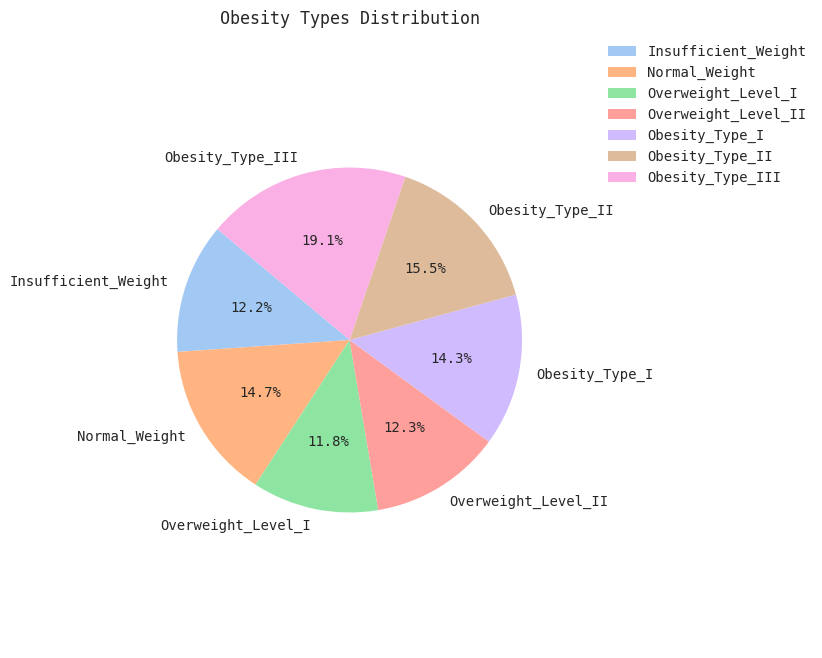

In [16]:
labels = nobeyesdadVC.index.tolist()
sizes = nobeyesdadVC.values.tolist()
colors = sns.color_palette('pastel')[0:10]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, radius=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title('Obesity Types Distribution')

plt.show()

### Distribution of categorical features

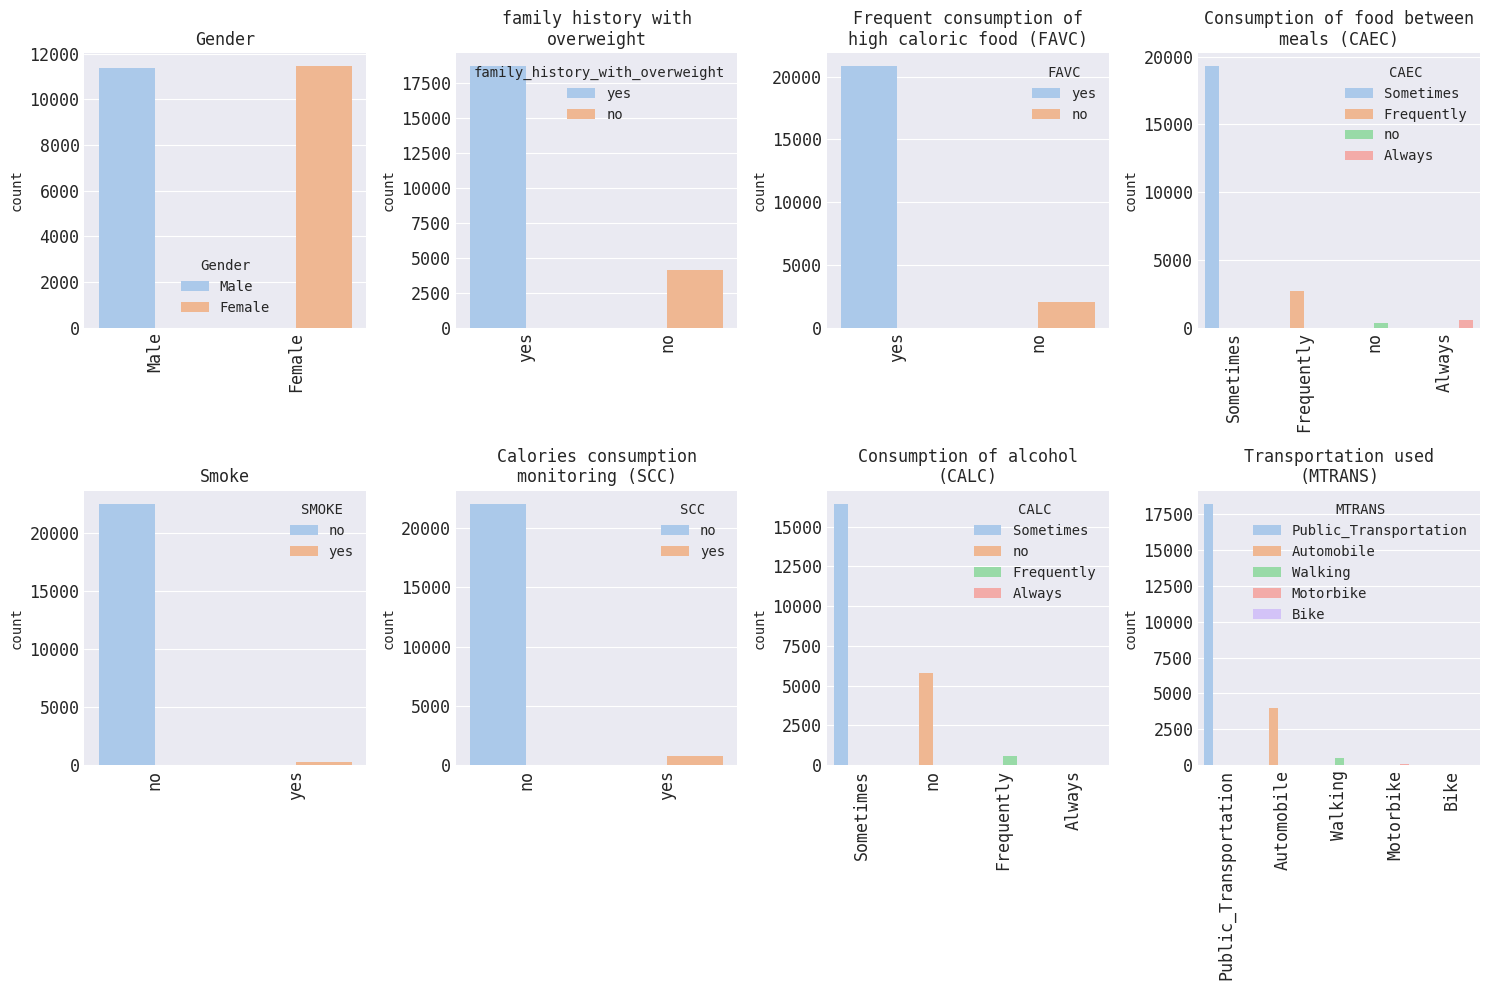

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

axes = axes.flatten()

num_columns_desc = ['Gender', 'family history with overweight', 'Frequent consumption of high caloric food (FAVC)', 'Consumption of food between meals (CAEC)', 'Smoke', 'Calories consumption monitoring (SCC)',
                'Consumption of alcohol (CALC)', 'Transportation used (MTRANS)']

for i, column in enumerate(df[categorical_cols].columns):
    sns.countplot(x=column, data=df, ax=axes[i], hue=column, palette='pastel')
    wrapped_title = '\n'.join(textwrap.wrap(f'{num_columns_desc[i]}', width=27))
    axes[i].set_title(wrapped_title)
    axes[i].title.set_size(12)
    axes[i].tick_params(axis='x', labelrotation=90)  
    axes[i].tick_params(axis='both', which='major', labelsize=12)  
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

### Distribution of numerical features

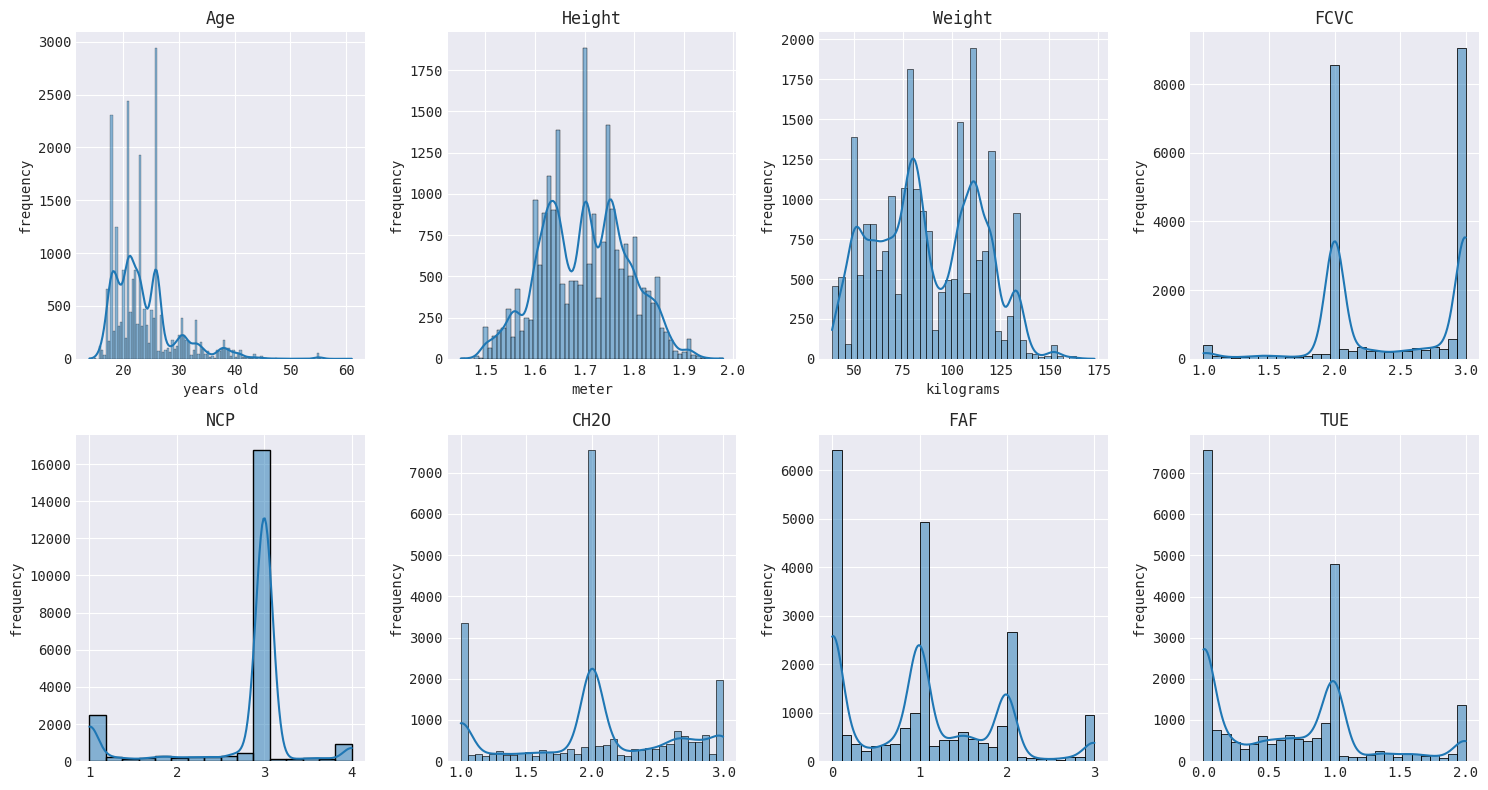

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 4*2))
axes = axes.flatten()

labels = ['years old', 'meter', 'kilograms', '', '', '','', '']

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, palette='pastel', kde=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].title.set_size(12)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel('frequency')
    
plt.tight_layout()
plt.show()

### Outlier detection for numerical columns

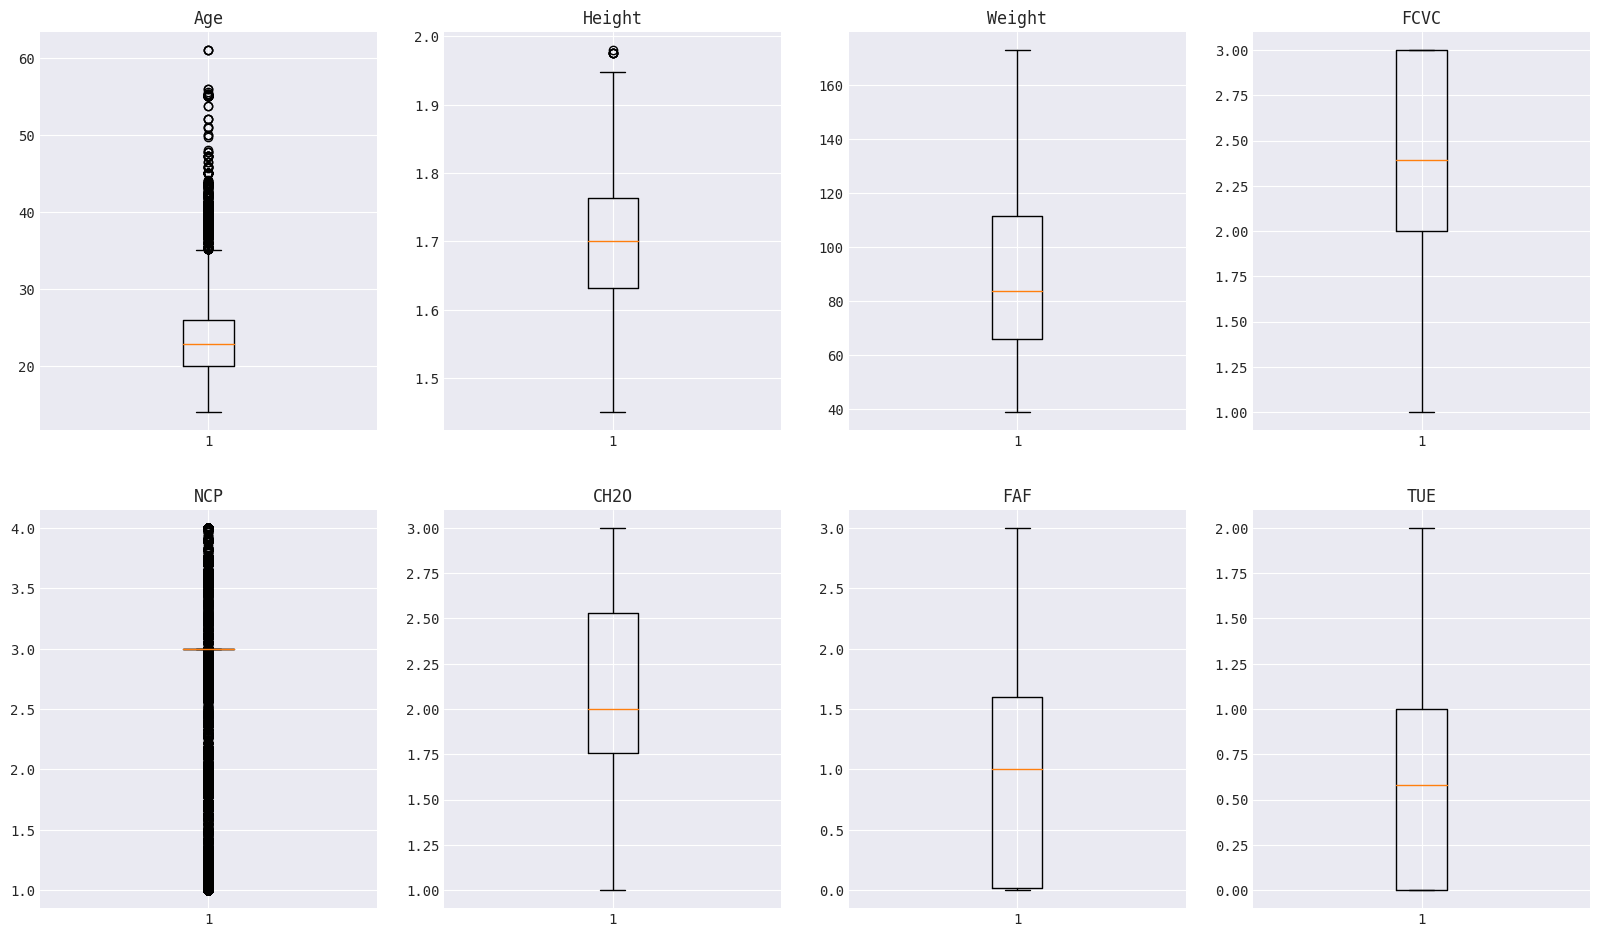

In [18]:
# Visualize the outliers using box plot
plt.figure(figsize=(20,30))
i = 1
columns_desc = ['Age', 'Height', 'Weight', 'Frequency of consumption of vegetables', 'Number of main meals', 'Consumption of water daily',
                'Physical activity frequency', 'Time using technology devices']
for col in numerical_cols:
    plt.subplot(5, 4, i)
    plt.boxplot(df[col], whis=1.5)
    plt.title(f'{col}')
    i += 1

### Relationship between numerical features and target classes

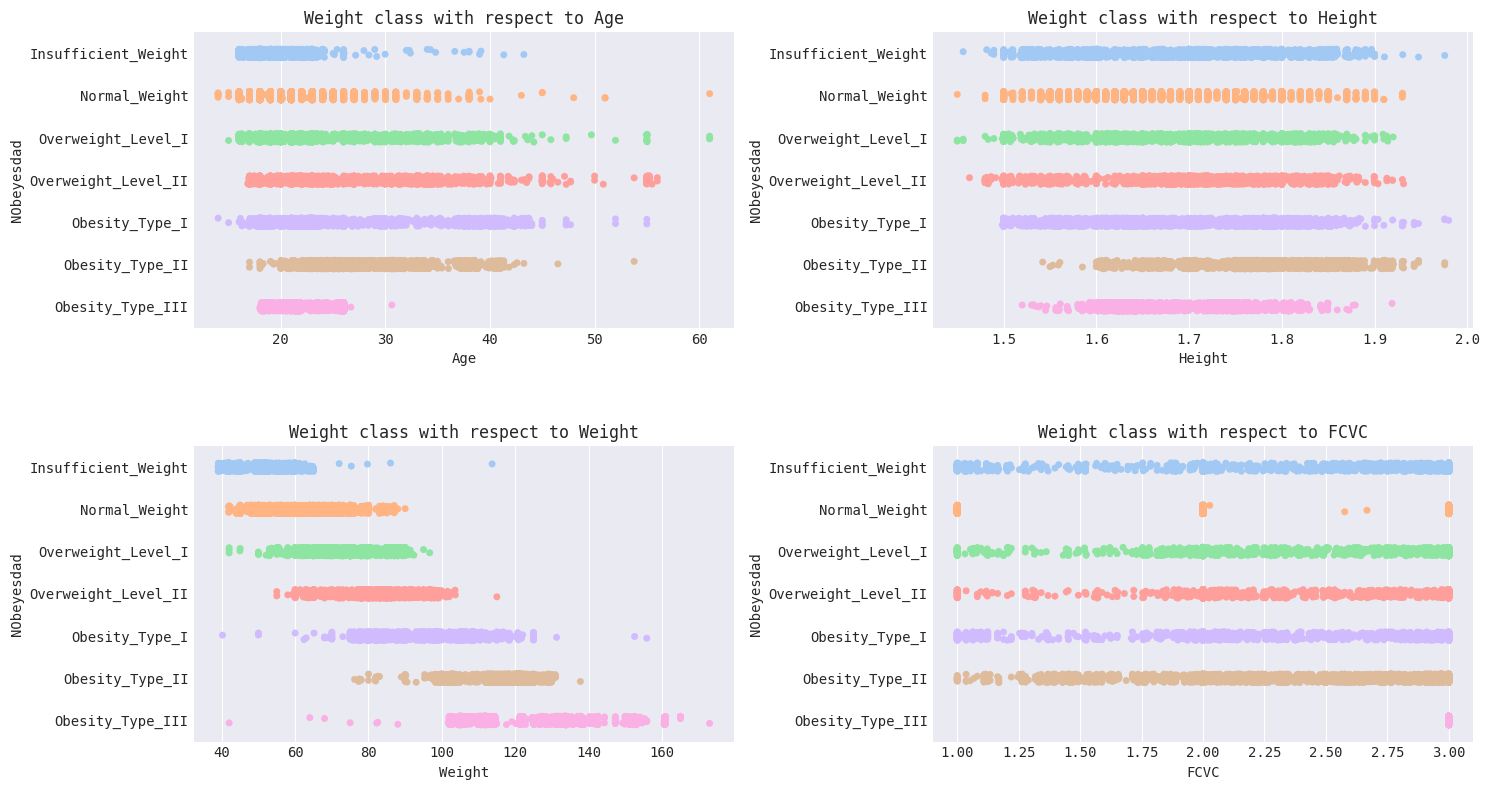

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 4*2))
axes = axes.flatten()
sns.stripplot(data=df, ax=axes[0], x='Age', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[1], x='Height', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[2], x='Weight', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[3], x='FCVC', y='NObeyesdad', palette='pastel', order=category_order)

# Title for each subplots
axes[0].set_title('Weight class with respect to Age')
axes[1].set_title('Weight class with respect to Height')
axes[2].set_title('Weight class with respect to Weight')
axes[3].set_title('Weight class with respect to FCVC')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 

# Show the plot
plt.show()

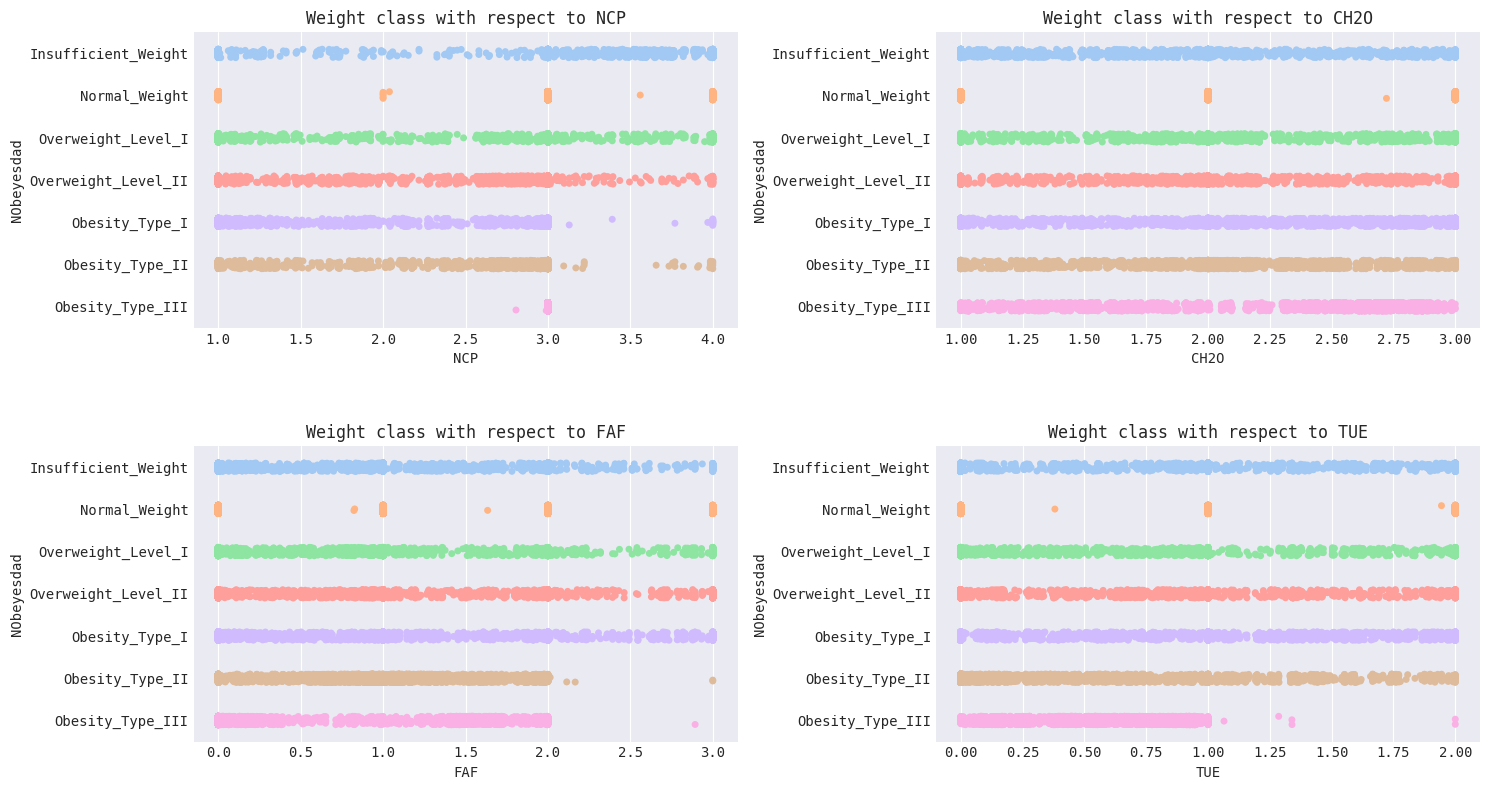

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 4*2))
axes = axes.flatten()
sns.stripplot(data=df, ax=axes[0], x='NCP', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[1], x='CH2O', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[2], x='FAF', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[3], x='TUE', y='NObeyesdad', palette='pastel', order=category_order)

# Title for each subplots
axes[0].set_title('Weight class with respect to NCP')
axes[1].set_title('Weight class with respect to CH2O')
axes[2].set_title('Weight class with respect to FAF')
axes[3].set_title('Weight class with respect to TUE')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 

# Show the plot
plt.show()

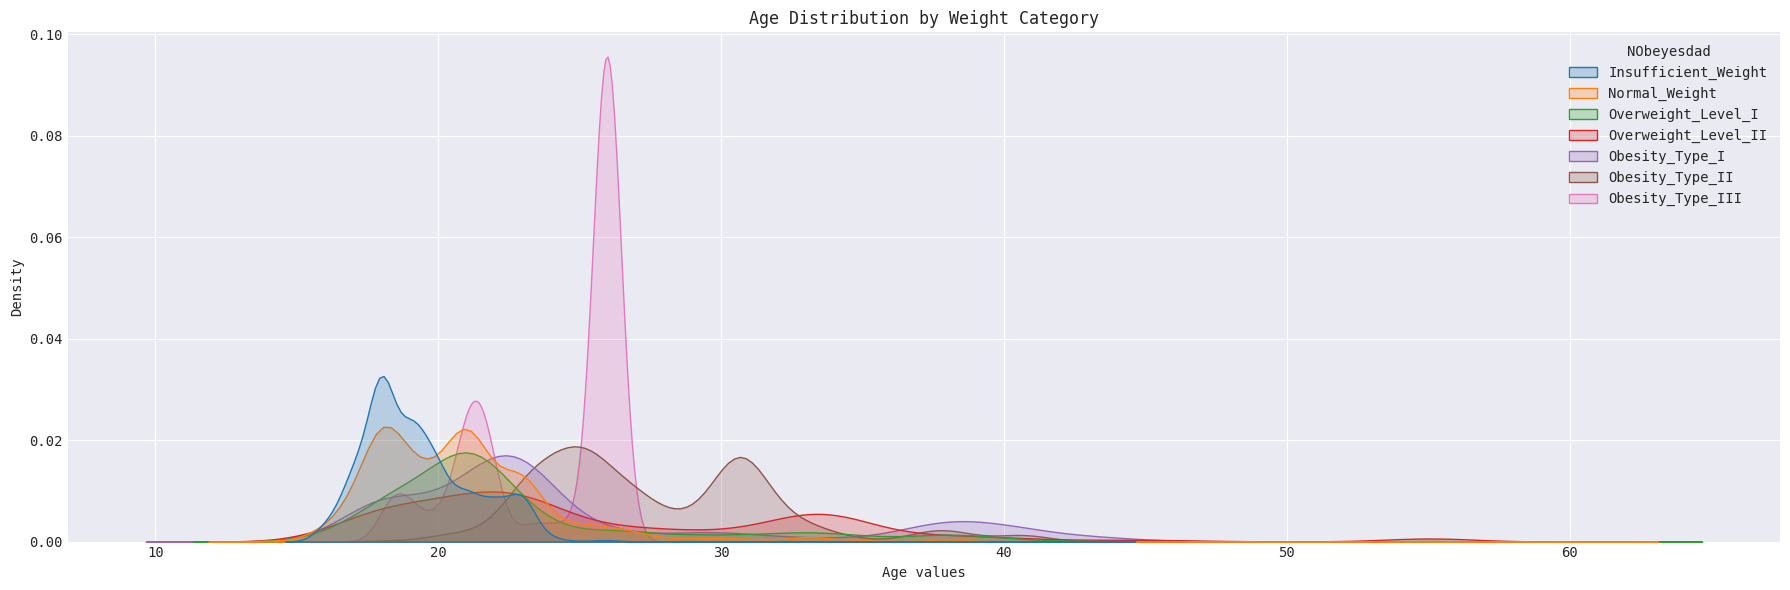

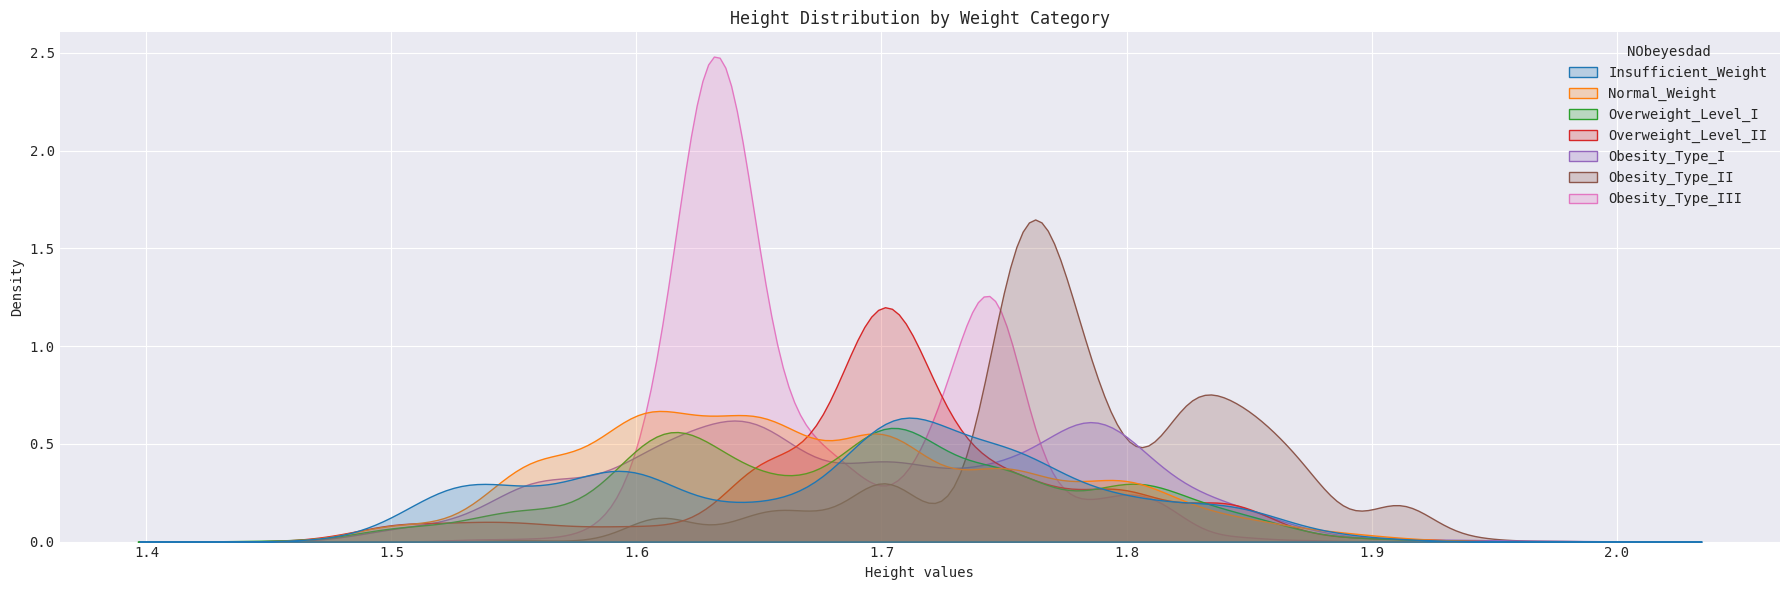

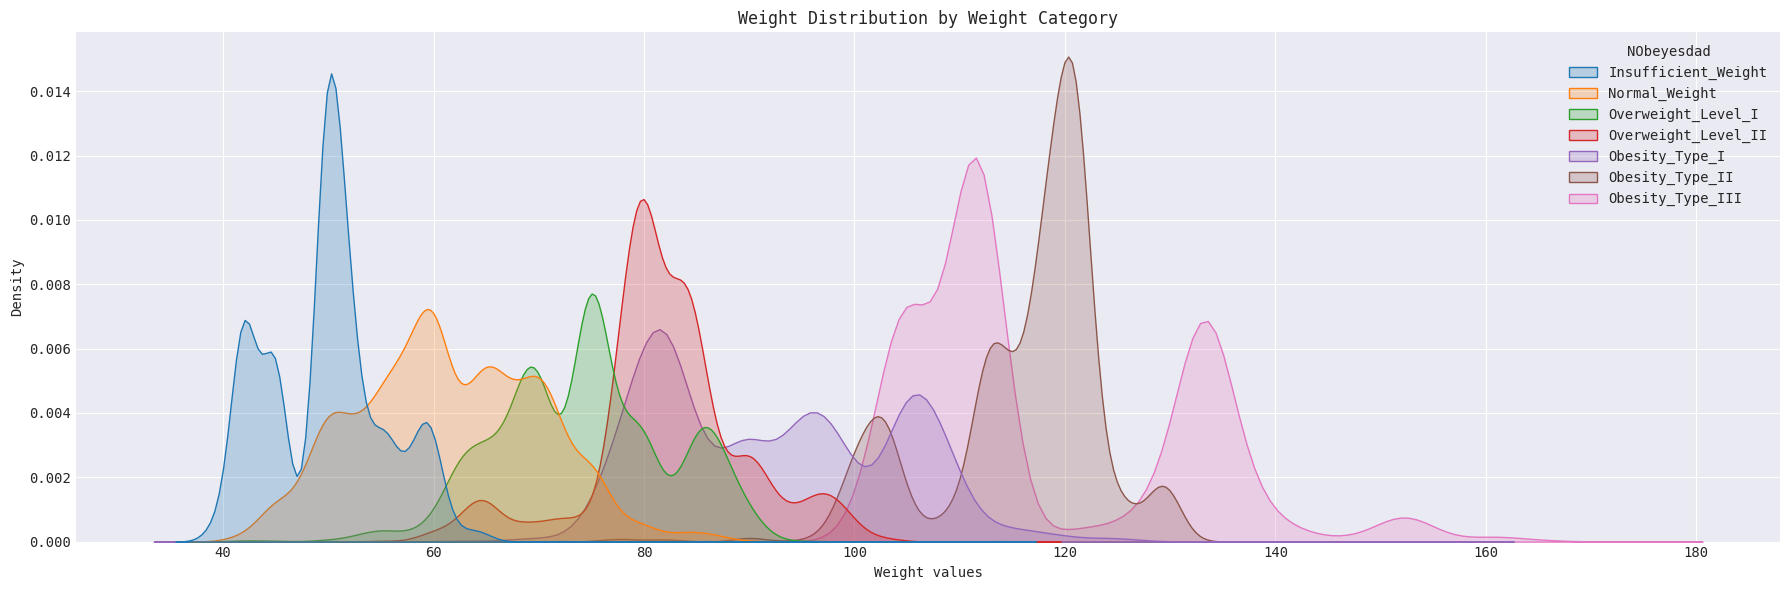

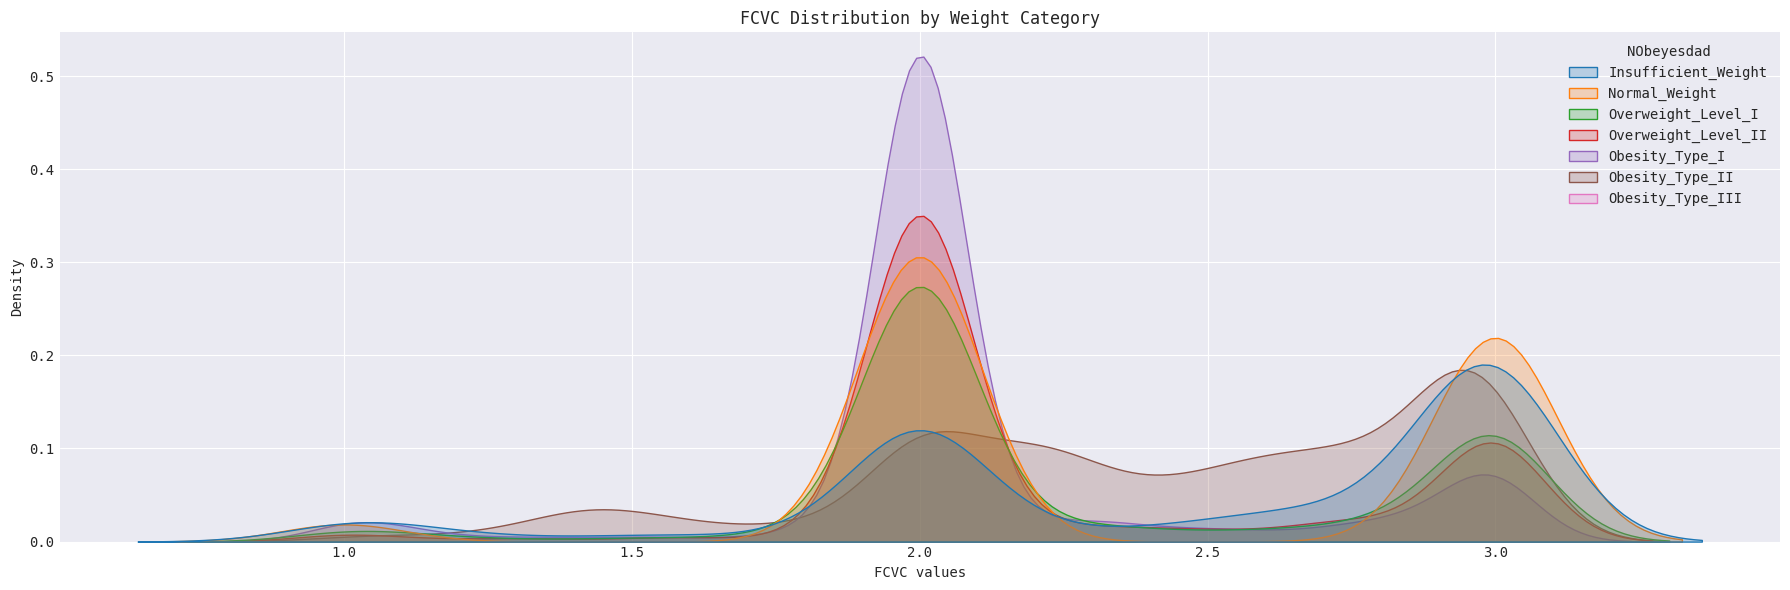

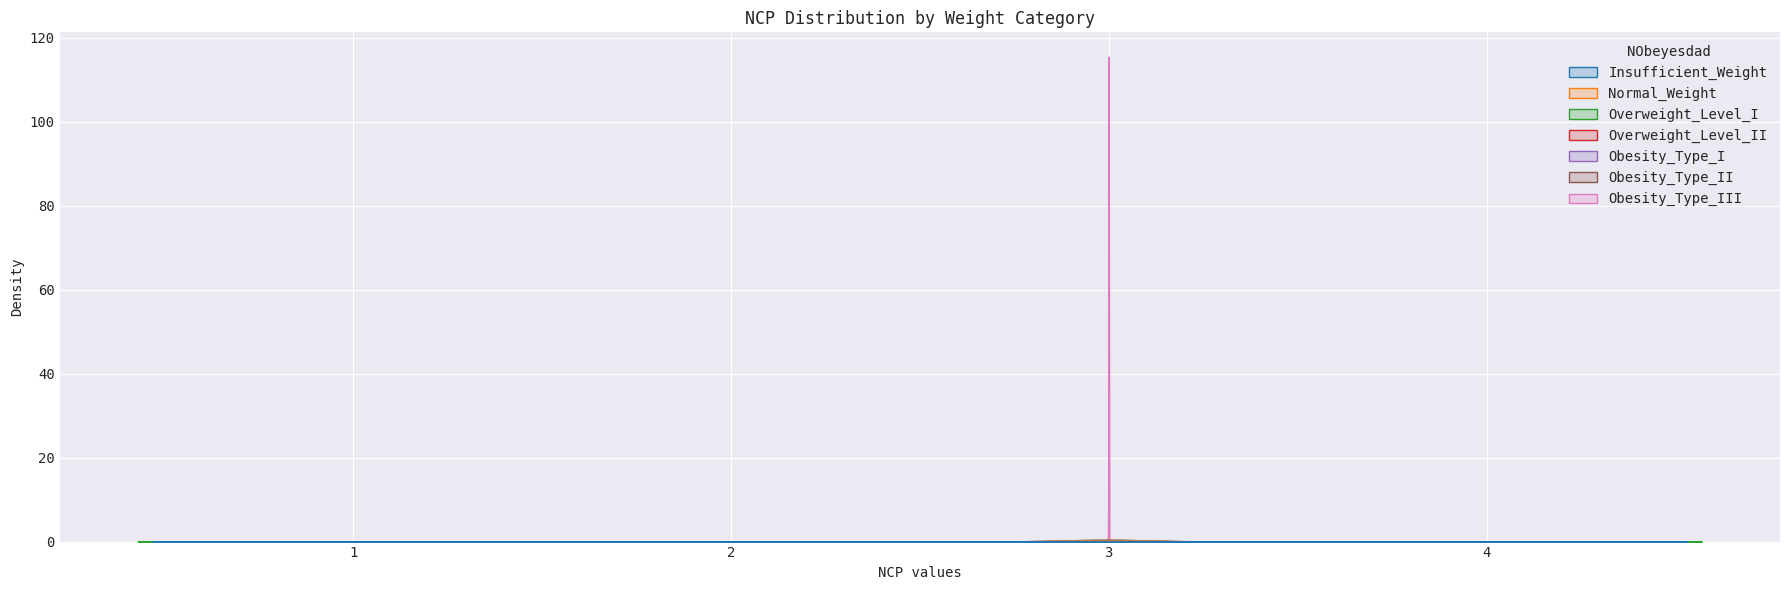

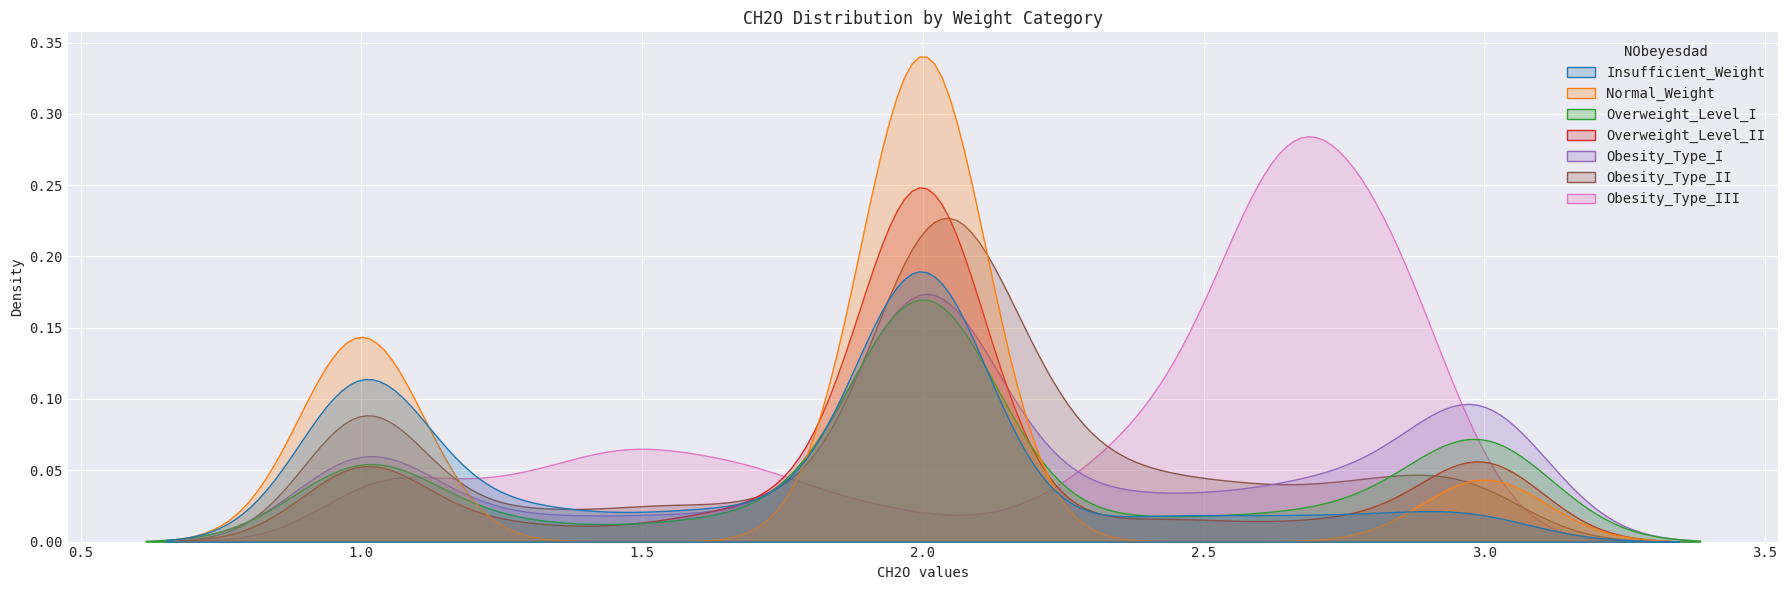

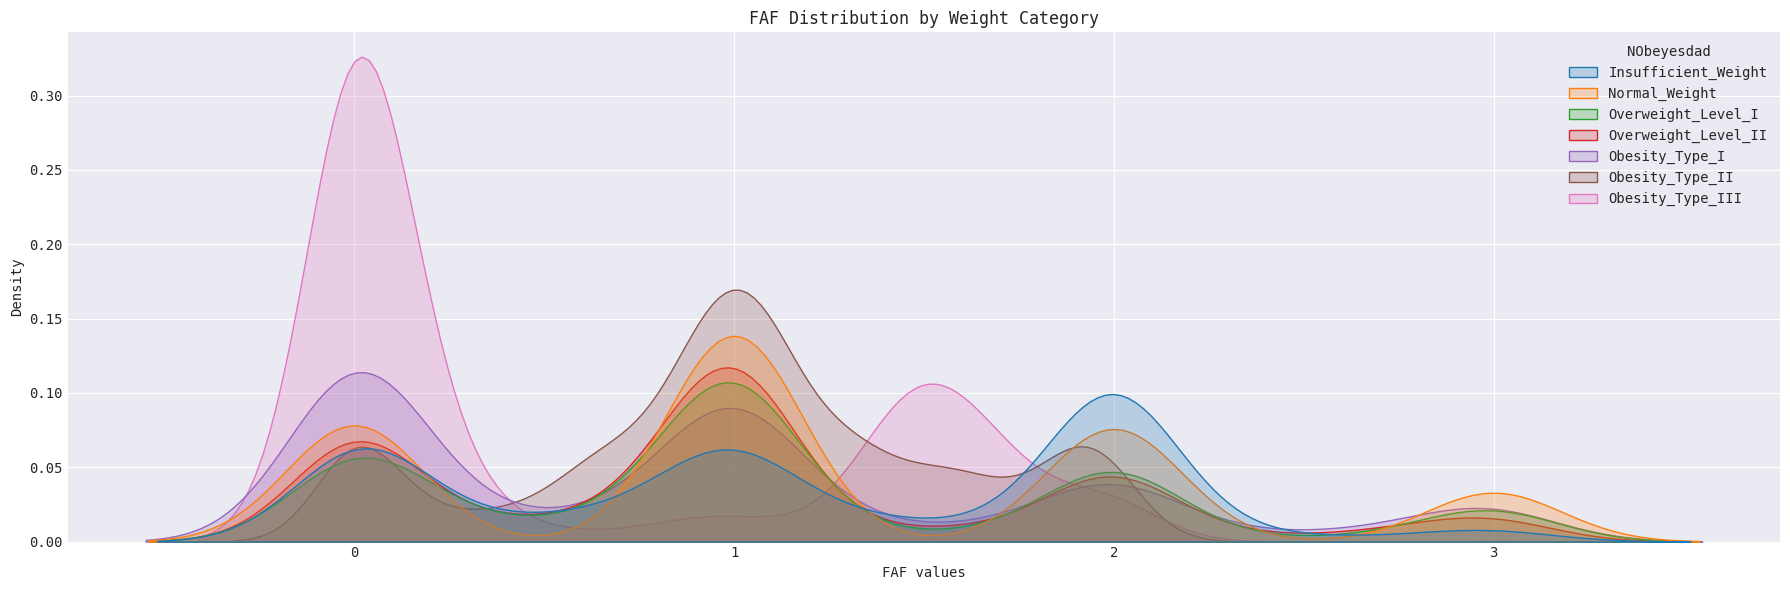

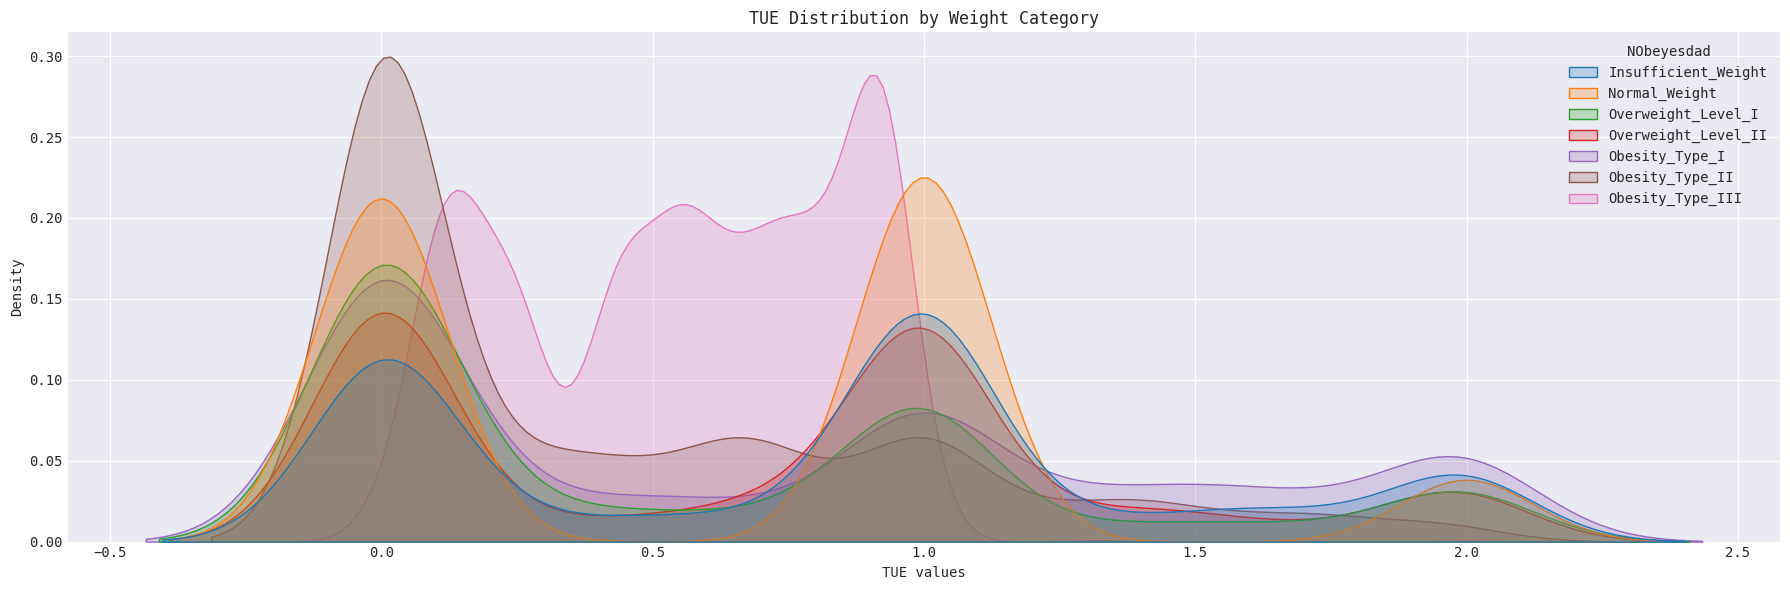

In [21]:
# Convert the 'NObeyesdad' column to categorical with the specified order
df['NObeyesdad'] = pd.Categorical(df['NObeyesdad'], categories=category_order, ordered=True)

# Map the categorical codes to integers
df['NObeyesdad_code'] = df['NObeyesdad'].cat.codes

# Sort the DataFrame based on 'NObeyesdad_code' (optional, for display purposes)
df_sorted = df.sort_values('NObeyesdad_code')
for col in numerical_cols:
    plt.figure(figsize=(18,6))
    # KDE plot for distribution
    sns.kdeplot(data=df_sorted, x=col, hue='NObeyesdad', palette=sns.color_palette("tab10"), 
                fill=True)
    plt.xlabel(f'{col} values')
    plt.title(f'{col} Distribution by Weight Category')
    
    plt.tight_layout()
    plt.show()

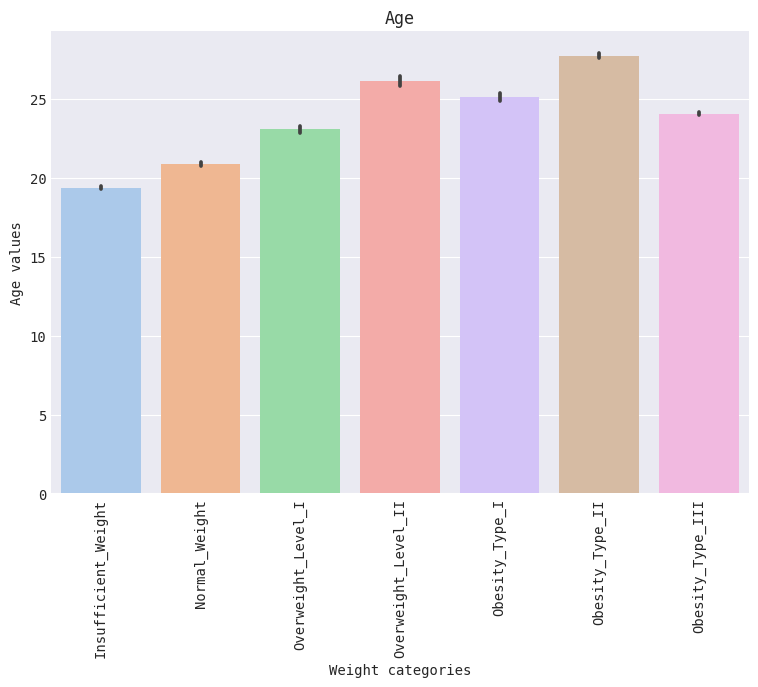

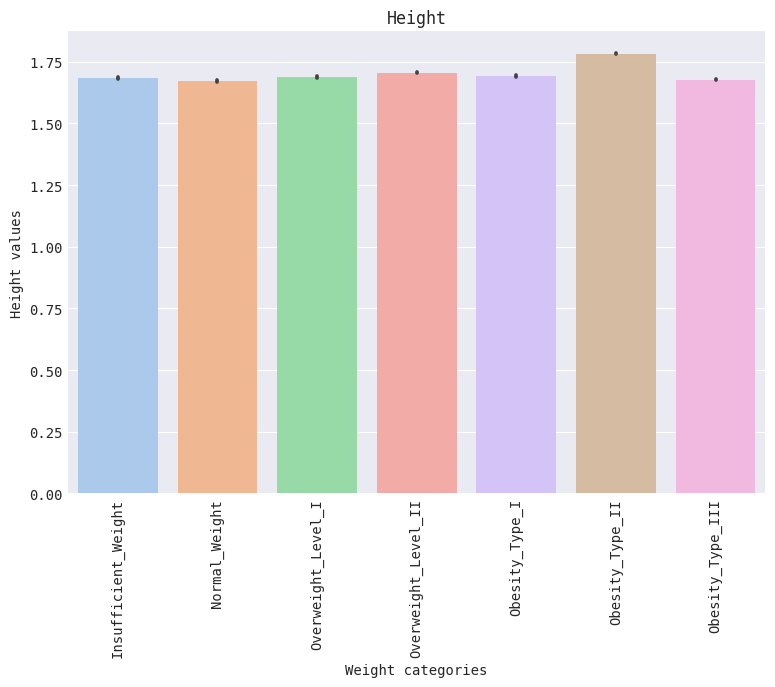

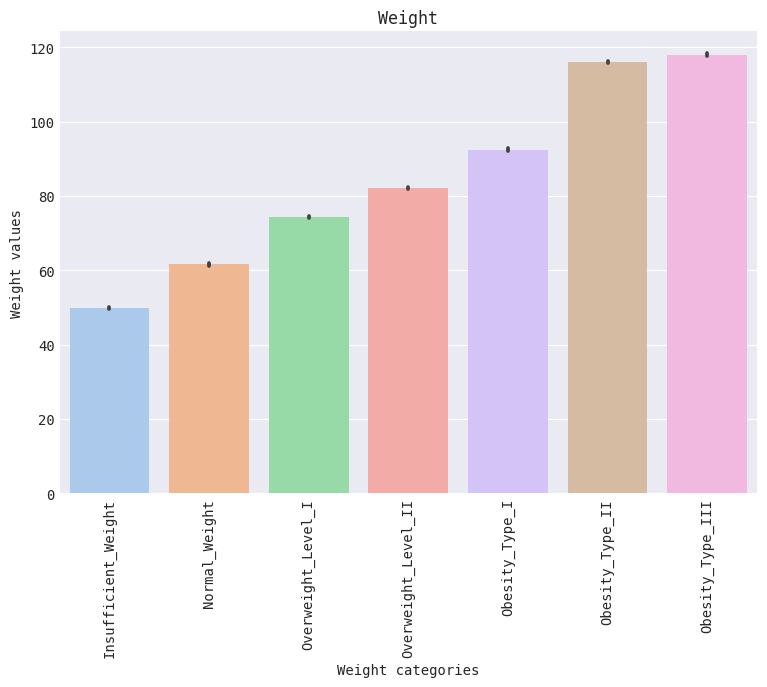

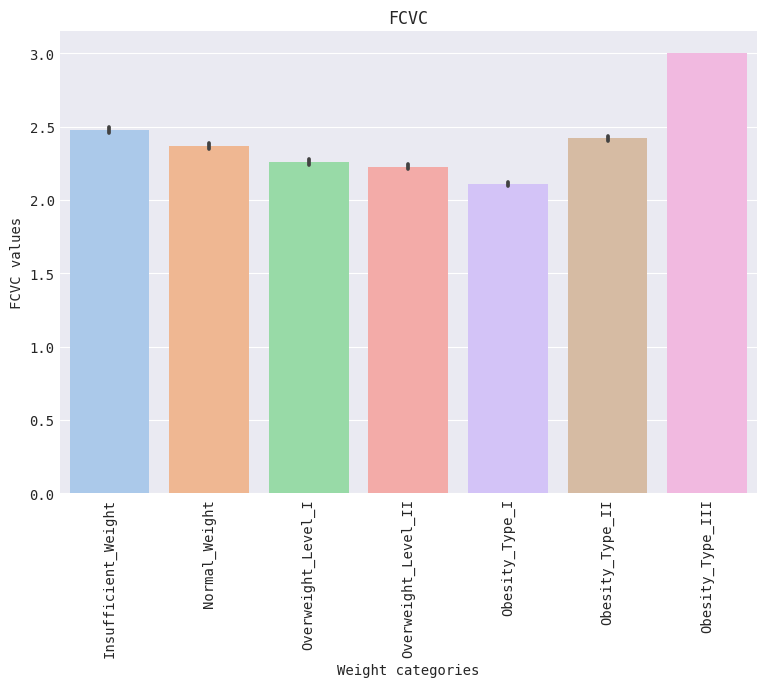

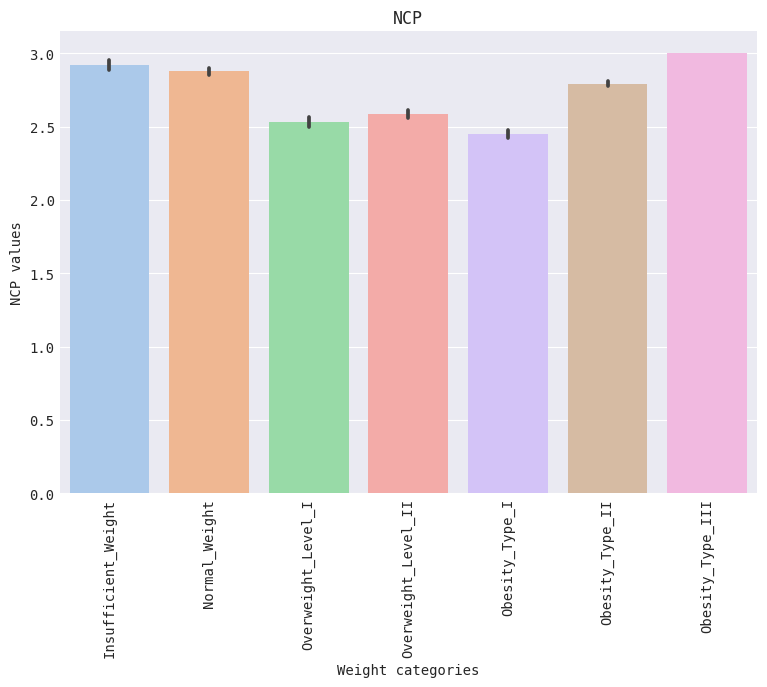

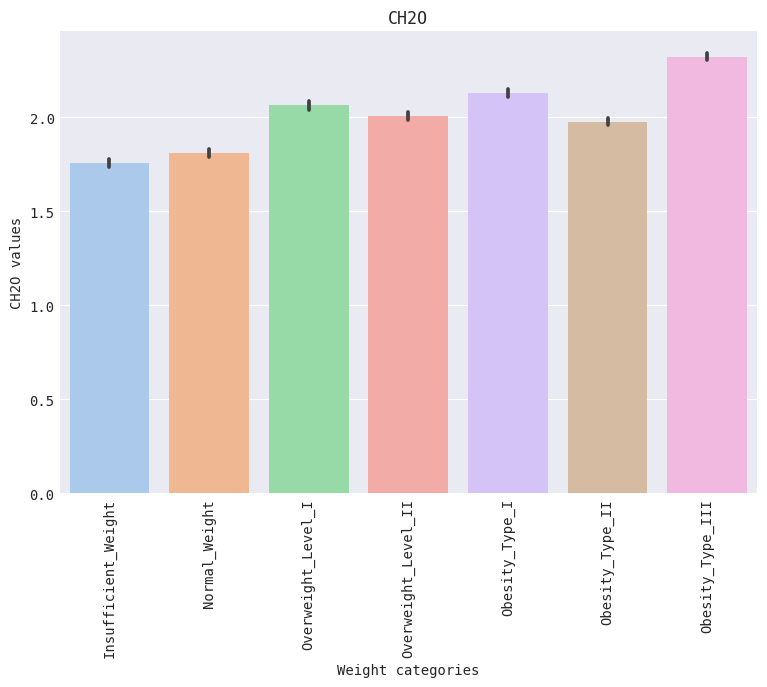

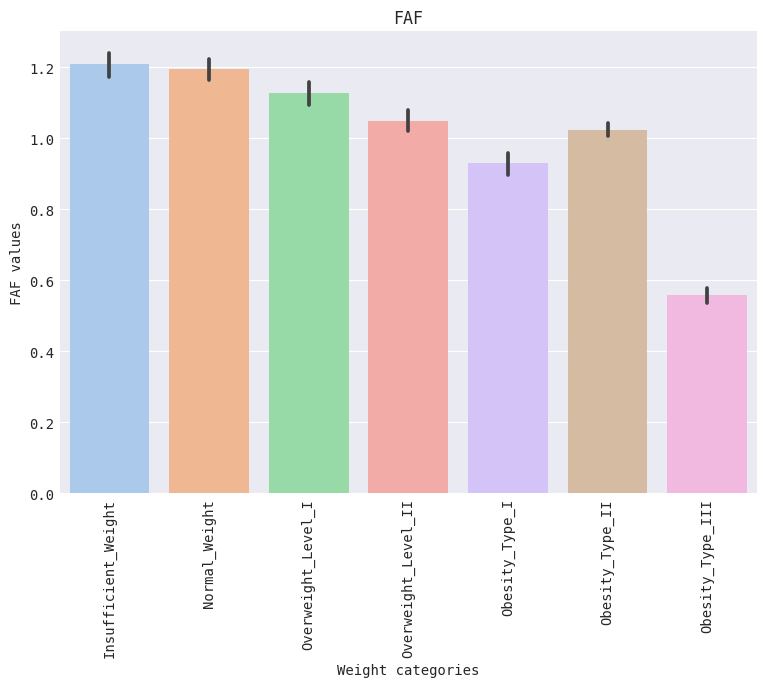

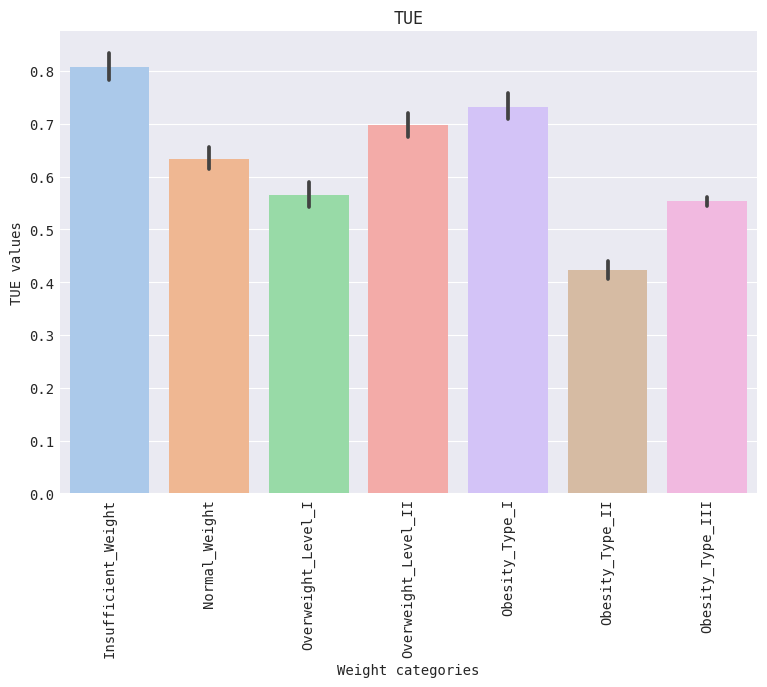

In [22]:
for col in numerical_cols:
    plt.figure(figsize=(9,6))
    sns.barplot(x='NObeyesdad', y=col, data=df, palette='pastel', order = category_order)
    plt.xticks(rotation=90)
    plt.xlabel('Weight categories')
    plt.ylabel(f'{col} values')
    plt.title(f'{col}')
    
plt.show()

### Relationship between categorical features and target classes

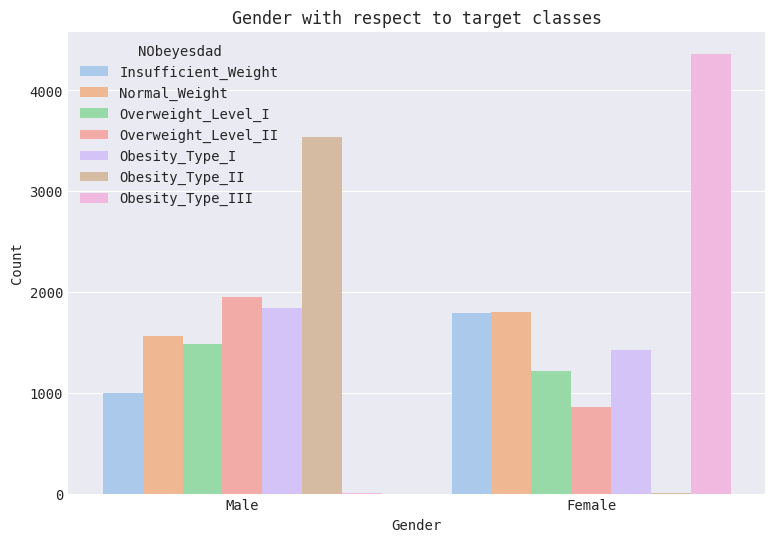

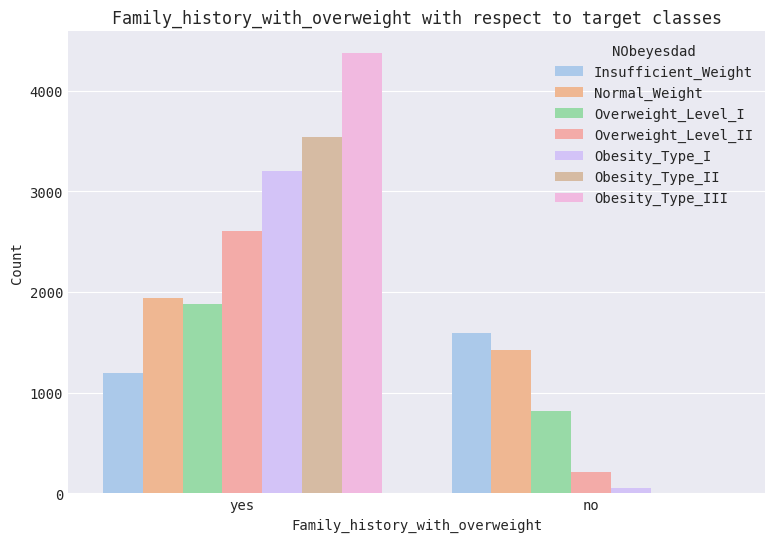

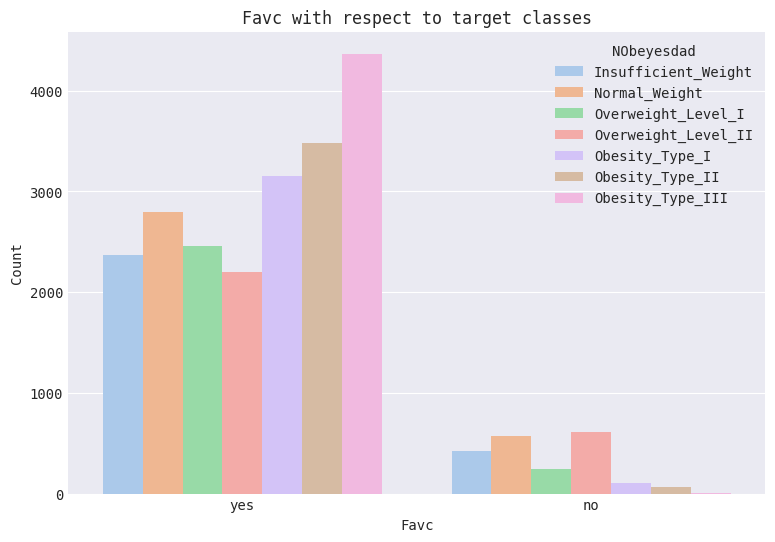

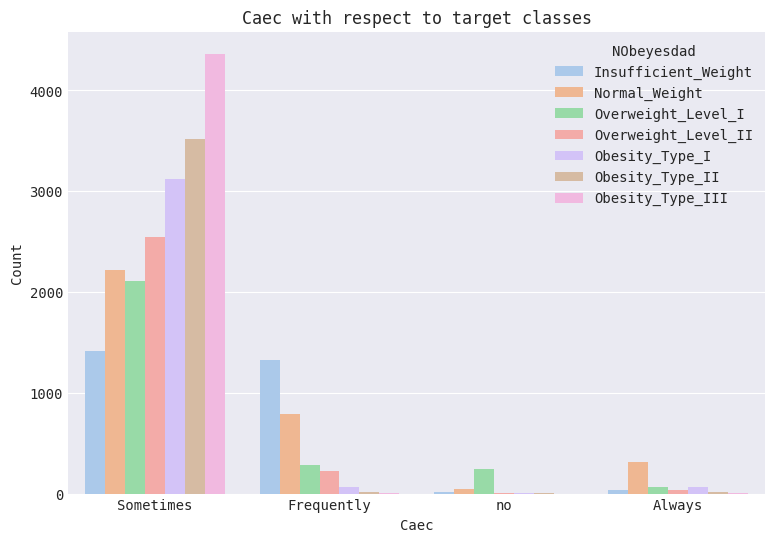

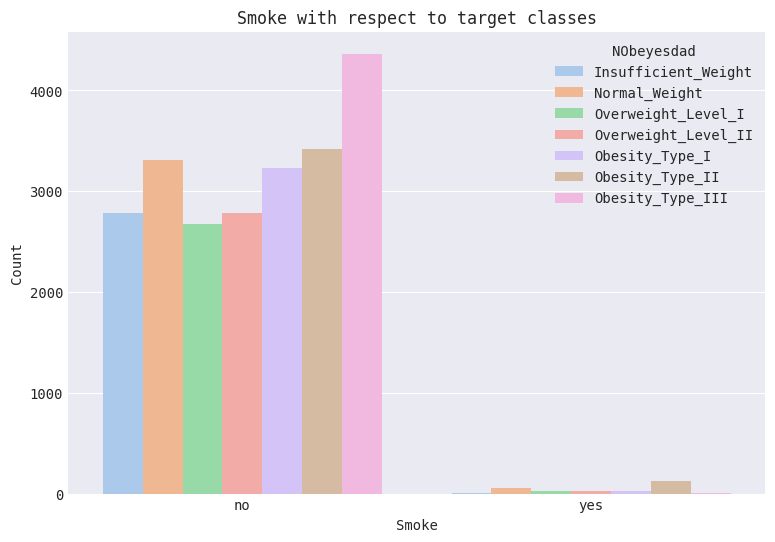

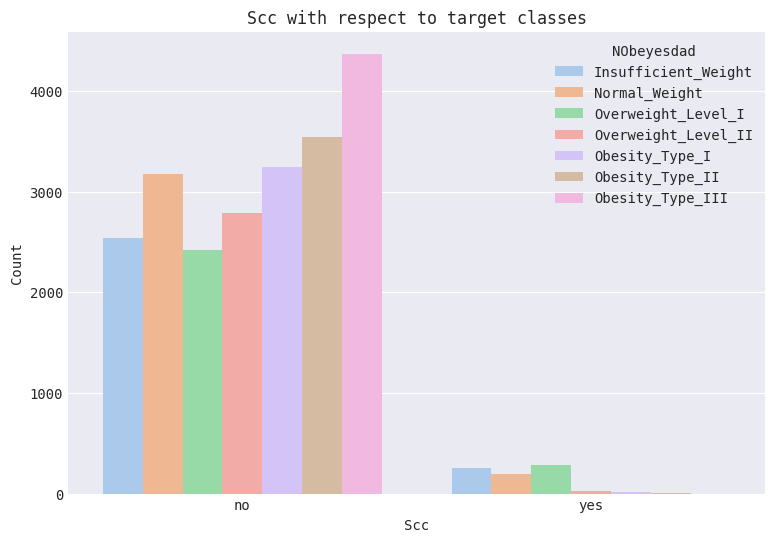

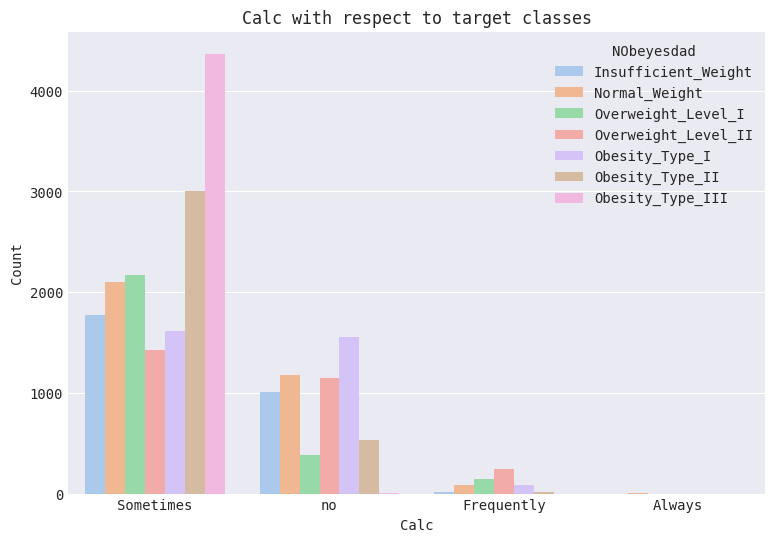

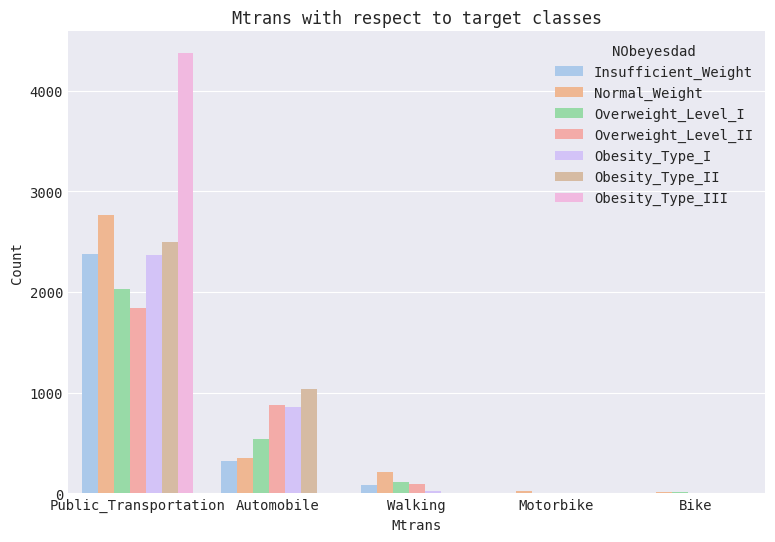

In [23]:
for col in categorical_cols:
    plt.figure(figsize=(9, 6))
    sns.countplot(data=df, x=col, hue='NObeyesdad', palette='pastel', hue_order=category_order)
    plt.title(f"{col.capitalize()} with respect to target classes")
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='NObeyesdad')
    plt.show()

### Relationship between features

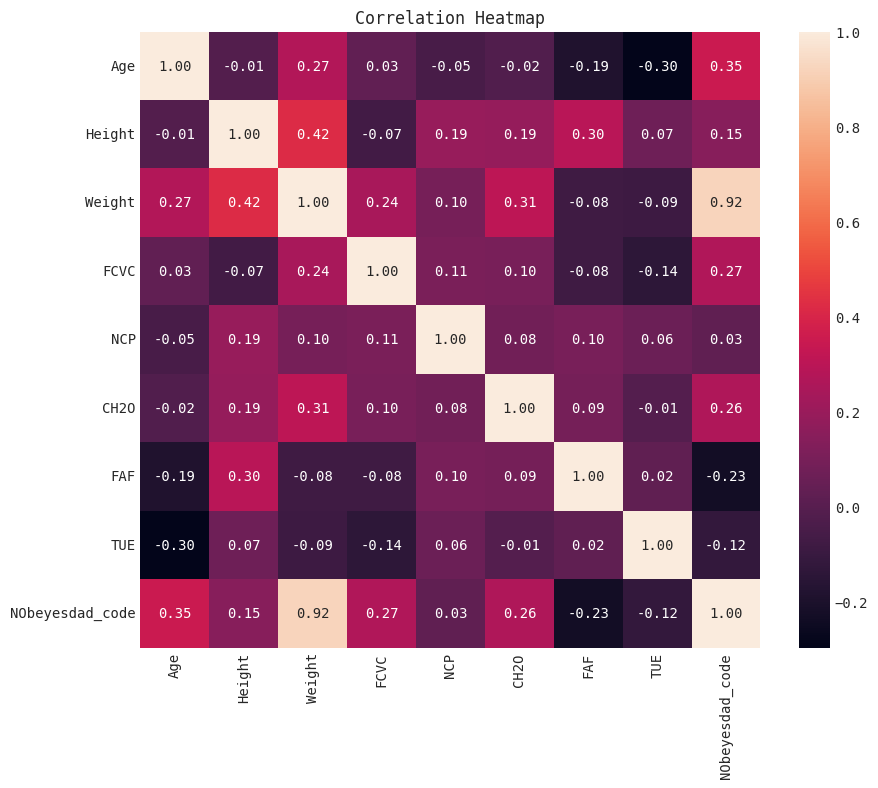

In [24]:
corr = df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

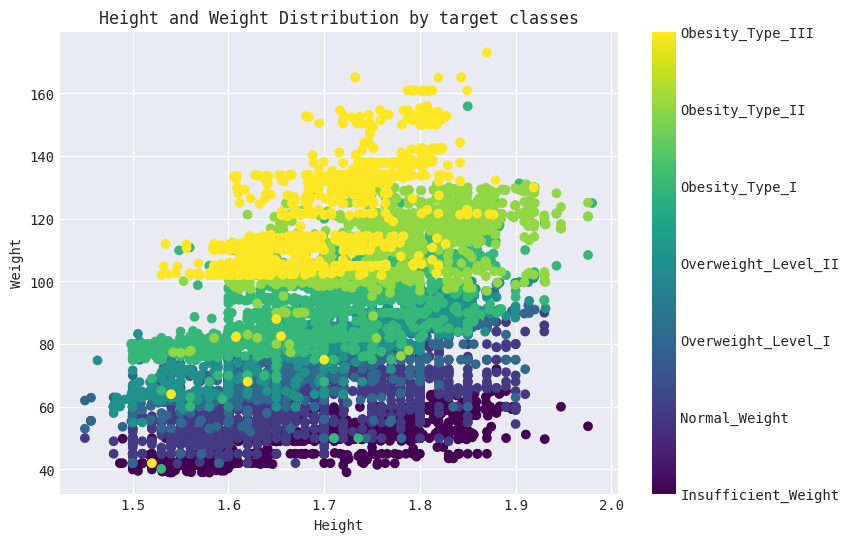

In [25]:
# Create the scatter plot
plt.figure(figsize=(9, 6))
scatter = plt.scatter(df_sorted['Height'], df_sorted['Weight'], c=df_sorted['NObeyesdad_code'], cmap='viridis')

# Set labels and title
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height and Weight Distribution by target classes')

# Customize the colorbar to match the category order
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(category_order)))
cbar.set_ticklabels(category_order)

# Display the plot
plt.show()

# 4. Data preprocessing

In [6]:
df = pd.read_csv('data/train.csv')
# drop id 
df.drop(columns='id', inplace=True)
df_original = pd.read_csv('data/ObesityDataSet.csv')
# Combine 2 datasets
df = pd.concat([df, df_original], ignore_index=True)

In [18]:
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object" and cname != 'NObeyesdad']
# Printing numerical and categorical column lists
print('Numerical Columns: ', numerical_cols)
print('Categorical Columns: ', categorical_cols)

Numerical Columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns:  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [19]:
#Split features and target label
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y = y.map(mapping)
print(y)

0        3
1        1
2        0
3        6
4        3
        ..
22840    6
22841    6
22842    6
22843    6
22844    6
Name: NObeyesdad, Length: 22845, dtype: int64


In [20]:
#Transform the distribution of Age into normal distribution
df['Age'], _  = boxcox(df['Age'])

Text(0, 0.5, 'frequency')

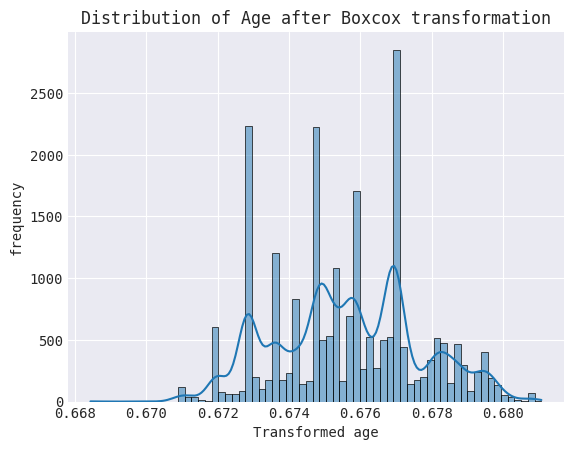

In [21]:
sns.histplot(data=df, x='Age', palette='pastel', kde=True)
plt.title('Distribution of Age after Boxcox transformation')
plt.xlabel('Transformed age')
plt.ylabel('frequency')

In [22]:
#Transform FCVC, NCP, CH2O, FAF, TUE into discrete values
df['FCVC'] = pd.cut(df['FCVC'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
df['NCP'] = pd.cut(df['NCP'],
                              bins=[0.5,1.5,2.5,3.5,4.5],
                              labels=[1,2,3,4]).astype('float64')
df['CH2O'] = pd.cut(df['CH2O'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
df['FAF'] = pd.cut(df['FAF'],
                              bins=[-0.5,0.5,1.5,2.5,3.5],
                              labels=[0,1,2,3]).astype('float64')
df['TUE'] = pd.cut(df['TUE'],
                              bins=[-0.5,0.5,1.5,2.5],
                              labels=[0,1,2]).astype('float64')

In [23]:
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_STATE)

In [24]:
print(X_train.shape)
print(X_test.shape)

(18276, 16)
(4569, 16)


In [34]:
#Check the distribution of target classes in train and test set
print(y_train.value_counts() / y_train.shape[0])
print(y_test.value_counts() / y_test.shape[0])

NObeyesdad
6    0.1911
5    0.1550
1    0.1473
4    0.1426
3    0.1229
0    0.1222
2    0.1188
Name: count, dtype: float64
NObeyesdad
6    0.1911
5    0.1550
1    0.1474
4    0.1425
3    0.1231
0    0.1222
2    0.1187
Name: count, dtype: float64


In [25]:
# data preprocessing, why not drop 1 col in 1-hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, ['Age', 'Height', 'Weight']),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight'])])

In [26]:
# Preprocess train and test sets
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

# Save the ColumnTransformer to a file
filename = os.path.join('checkpoint/', 'preprocessing.joblib')
joblib.dump(col_trans,filename)

['checkpoint/preprocessing.joblib']

In [37]:
X_train

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,ordinalencoder__CAEC,ordinalencoder__CALC,standardscaler__Age,standardscaler__Height,standardscaler__Weight,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
19926,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.6586,0.4697,1.5563,3.0000,3.0000,2.4441,0.1109,0.7786
15522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.5985,0.2287,-0.1796,2.0000,1.0000,2.0000,1.0000,0.0000
15970,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.6584,0.4045,1.8990,3.0000,3.0000,2.3880,1.9263,0.9230
18897,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.6459,1.8008,0.3735,2.0000,3.0000,3.0000,1.1910,1.0407
11157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.0262,0.0014,-1.4314,2.0000,4.0000,1.0000,2.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.7738,-1.9132,-0.9430,2.0482,1.0000,1.2747,1.6127,1.0000
21302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,-0.6051,0.6378,-1.2911,2.0000,3.8920,1.8639,2.8701,2.0000
666,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.3737,-0.8519,0.9161,3.0000,3.0000,2.7091,0.0000,0.2004
4435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.3072,1.6874,1.2736,2.1753,2.5629,1.0000,0.9034,0.0000


In [38]:
#check if mean = 0 and std = 1 or not
print(X_train['standardscaler__Age'].mean())
print(X_train['standardscaler__Age'].std())

-8.835663972966536e-17
1.0000273309919836


# 5. Experiment

In [39]:
# Create DataFrame to store model performances
df_results = pd.DataFrame()

In [40]:
#function to tune hyperparameters
def hyper_search(model, model_name, param_grid, X_train, y_train, cv=5, n_iter=20, scoring='accuracy', random_state=RANDOM_STATE):
    global df_results
    # Hyperparameter tuning
    rs = RandomizedSearchCV(model, param_grid, n_iter=n_iter, n_jobs=-1, cv=StratifiedKFold(n_splits=cv), scoring=scoring, return_train_score=True, random_state=random_state)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    
    #add the report about best hyperparameter of the model to dataframe
    result = pd.DataFrame(rs.cv_results_)
    result.sort_values('rank_test_score', inplace=True)
    result = result[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']]
    display(result)
    best_hyper = result.loc[result['params']==rs.best_params_]
    best_hyper['model_name'] = model_name
    df_results = pd.concat([df_results, best_hyper], ignore_index=True)
    
    #save the model
    filename = os.path.join('checkpoint/', f'{model_name}.joblib')
    joblib.dump(best_model,filename)
    
#     #save report results
#     df_results.to_csv('report_result.csv')
    
    return best_model

## 5.1 KNN

In [41]:
param_grid = [{
        'n_neighbors': [2, 5, 8, 10, 20],
        'p': [1, 2],
}]
knn = hyper_search(KNeighborsClassifier(), 'knn', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
8,"{'p': 1, 'n_neighbors': 20}",0.0117,3.4113,0.8297,0.8484
6,"{'p': 1, 'n_neighbors': 10}",0.0115,3.3076,0.8280,0.8627
4,"{'p': 1, 'n_neighbors': 8}",0.0114,3.3052,0.8272,0.8660
2,"{'p': 1, 'n_neighbors': 5}",0.0127,3.3420,0.8193,0.8773
7,"{'p': 2, 'n_neighbors': 10}",0.0114,0.8605,0.8025,0.8390
5,"{'p': 2, 'n_neighbors': 8}",0.0137,0.9487,0.7998,0.8466
9,"{'p': 2, 'n_neighbors': 20}",0.0116,0.8811,0.7968,0.8197
3,"{'p': 2, 'n_neighbors': 5}",0.0117,0.8607,0.7956,0.8613
0,"{'p': 1, 'n_neighbors': 2}",0.0161,3.4240,0.7790,0.8966
1,"{'p': 2, 'n_neighbors': 2}",0.0113,0.8641,0.7642,0.8891


## 5.2. Logistic Regression

In [42]:
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000],
        'penalty': ['l2']
    },
{
    'penalty': [None]
}]
logreg = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
2,"{'penalty': 'l2', 'C': 10}",15.6687,0.0051,0.8700,0.8720
3,"{'penalty': 'l2', 'C': 100}",31.1332,0.0053,0.8700,0.8725
4,"{'penalty': 'l2', 'C': 1000}",35.6433,0.0054,0.8699,0.8725
5,{'penalty': None},37.5202,0.0043,0.8697,0.8725
1,"{'penalty': 'l2', 'C': 1}",7.0759,0.0053,0.8656,0.8677
0,"{'penalty': 'l2', 'C': 0.1}",4.4298,0.0052,0.8350,0.8369


## 5.3. Decision Tree

In [43]:
param_grid = [{
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [5, 10, 20, 30, 50],
        'criterion': ['gini', 'entropy']
    }]
decision_tree = hyper_search(DecisionTreeClassifier(random_state=RANDOM_STATE), 'decision_tree', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
3,"{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}",0.1437,0.0051,0.8831,0.9071
7,"{'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'entropy'}",0.1486,0.0055,0.8823,0.8976
10,"{'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy'}",0.1459,0.0051,0.8820,0.9144
19,"{'min_samples_leaf': 30, 'max_depth': 15, 'criterion': 'entropy'}",0.1273,0.0045,0.8819,0.8909
6,"{'min_samples_leaf': 20, 'max_depth': 20, 'criterion': 'entropy'}",0.1650,0.0082,0.8817,0.8986
16,"{'min_samples_leaf': 20, 'max_depth': 20, 'criterion': 'gini'}",0.1216,0.0053,0.8816,0.8974
5,"{'min_samples_leaf': 20, 'max_depth': 15, 'criterion': 'gini'}",0.1245,0.0062,0.8816,0.8974
12,"{'min_samples_leaf': 30, 'max_depth': 15, 'criterion': 'gini'}",0.1134,0.0053,0.8814,0.8912
15,"{'min_samples_leaf': 30, 'max_depth': 10, 'criterion': 'gini'}",0.1076,0.0052,0.8811,0.8909
9,"{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'gini'}",0.1155,0.0049,0.8802,0.9060


## 5.4. Random Forest

In [44]:
param_grid = [{
        'n_estimators': [100, 300, 500, 1000, 2000],
        'max_depth': [10, 20, 30],
        'min_samples_leaf': [10, 20, 30],
        'criterion': ['gini', 'entropy']
    }]
random_forest = hyper_search(RandomForestClassifier(random_state=RANDOM_STATE), 'random_forest', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
19,"{'n_estimators': 500, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy'}",14.4901,0.4004,0.8965,0.9222
16,"{'n_estimators': 1000, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'gini'}",24.5074,0.8482,0.8956,0.9216
18,"{'n_estimators': 2000, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}",56.5501,1.4682,0.8917,0.9141
15,"{'n_estimators': 2000, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'gini'}",44.7706,1.5665,0.8904,0.9117
6,"{'n_estimators': 2000, 'min_samples_leaf': 20, 'max_depth': 30, 'criterion': 'gini'}",44.7748,1.5418,0.8882,0.9064
10,"{'n_estimators': 300, 'min_samples_leaf': 20, 'max_depth': 30, 'criterion': 'entropy'}",8.6514,0.2336,0.8880,0.9066
1,"{'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 20, 'criterion': 'gini'}",11.0895,0.3889,0.8879,0.9063
11,"{'n_estimators': 100, 'min_samples_leaf': 20, 'max_depth': 30, 'criterion': 'gini'}",2.2172,0.0799,0.8865,0.9044
7,"{'n_estimators': 100, 'min_samples_leaf': 20, 'max_depth': 20, 'criterion': 'entropy'}",3.0099,0.0897,0.8863,0.9050
4,"{'n_estimators': 100, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'gini'}",2.4740,0.0815,0.8858,0.9087


## 5.5. XGBoost

In [45]:
param_grid = [{
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 15, 20]
    }]
xg_boost = hyper_search(XGBClassifier(random_state=RANDOM_STATE), 'xg_boost', param_grid, X_train, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
7,"{'n_estimators': 500, 'max_depth': 15}",24.1672,0.7437,0.9057,1.0000
6,"{'n_estimators': 300, 'max_depth': 15}",16.4752,0.5553,0.9055,1.0000
0,"{'n_estimators': 100, 'max_depth': 10}",6.3175,0.1774,0.9051,0.9999
5,"{'n_estimators': 200, 'max_depth': 15}",12.2354,0.3745,0.9051,1.0000
4,"{'n_estimators': 100, 'max_depth': 15}",7.1653,0.2139,0.9048,1.0000
11,"{'n_estimators': 500, 'max_depth': 20}",22.8552,0.6701,0.9047,1.0000
10,"{'n_estimators': 300, 'max_depth': 20}",16.3073,0.5154,0.9046,1.0000
2,"{'n_estimators': 300, 'max_depth': 10}",15.9453,0.4860,0.9043,1.0000
9,"{'n_estimators': 200, 'max_depth': 20}",12.4350,0.3785,0.9041,1.0000
8,"{'n_estimators': 100, 'max_depth': 20}",7.5500,0.2092,0.9037,1.0000


## 5.6. Voting Classifier

In [46]:
clf1 = XGBClassifier(random_state=RANDOM_STATE, n_estimators = 500, max_depth = 15)
clf2 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = 'entropy')
clf3 = XGBClassifier(random_state=RANDOM_STATE, n_estimators = 100, max_depth = 10)
votingClf = VotingClassifier(estimators=[
        ('xg1', clf1), ('rf2', clf2), ('xg3', clf3)], voting='soft')
votingClf_results = cross_validate(votingClf, X_train, y_train, cv=5, n_jobs=-1, return_train_score=True)

In [47]:
votingClf_result = {
        'params': 'XGBClassifier(n_estimators = 500, max_depth = 15); RandomForestClassifier(n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = ''entropy''); XGBClassifier(n_estimators = 100, max_depth = 10)',
        'mean_fit_time': np.mean(votingClf_results['fit_time']),
        'mean_score_time': np.mean(votingClf_results['score_time']),
        'mean_test_score': np.mean(votingClf_results['test_score']),
        'mean_train_score': np.mean(votingClf_results['train_score']),
        'model_name': 'voting_classifier'
    }
df_results = pd.concat([df_results, pd.DataFrame([votingClf_result])], ignore_index=True)

In [48]:
votingClf.fit(X_train, y_train)

VotingClassifier(estimators=[('xg1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [49]:
#save the model
filename = os.path.join('checkpoint/', 'votingClassifier.joblib')
joblib.dump(votingClf,filename)

['/kaggle/working/votingClassifier.joblib']

In [50]:
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 20}",0.0117,3.4113,0.8297,0.8484,knn
1,"{'penalty': 'l2', 'C': 10}",15.6687,0.0051,0.8700,0.8720,logistic_regression
2,"{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}",0.1437,0.0051,0.8831,0.9071,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy'}",14.4901,0.4004,0.8965,0.9222,random_forest
4,"{'n_estimators': 500, 'max_depth': 15}",24.1672,0.7437,0.9057,1.0000,xg_boost
5,"XGBClassifier(n_estimators = 500, max_depth = 15); RandomForestClassifier(n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = entropy); XGBClassifier(n_estimators = 100, max_depth = 10)",43.9071,1.2480,0.9072,1.0000,voting_classifier


In [51]:
df_results.to_csv('result_report.csv')

## 5.7. Feature Engineering

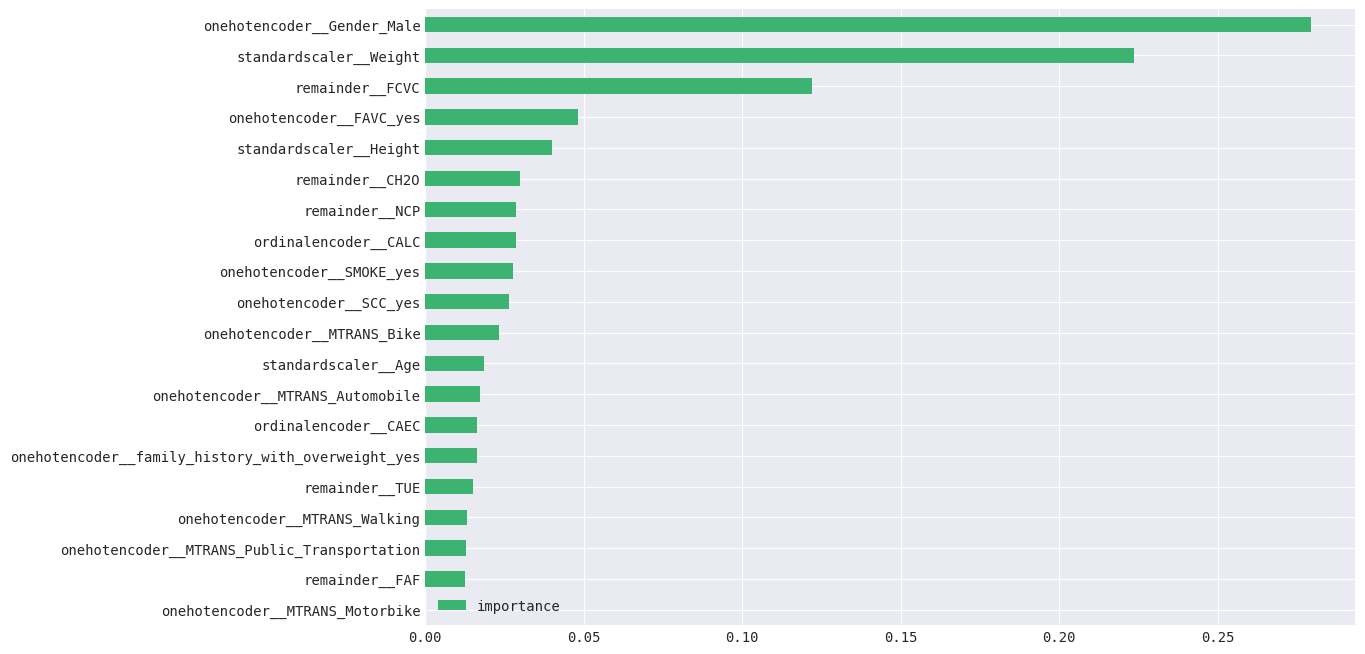

In [52]:
importance = xg_boost.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X_train.columns, columns=['importance']).sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

In [53]:
df = pd.read_csv('data/train.csv')
# drop id 
df.drop(columns='id', inplace=True)
df_original = pd.read_csv('data/ObesityDataSet.csv')
# Combine 2 datasets
df = pd.concat([df, df_original], ignore_index=True)

In [54]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['BMI'] = df_copy['Weight'] / (df_copy['Height'] ** 2)
    
    df_copy['Age'], _  = boxcox(df_copy['Age'])
    
    df_copy['FCVC'] = pd.cut(df_copy['FCVC'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
    df_copy['NCP'] = pd.cut(df_copy['NCP'],
                              bins=[0.5,1.5,2.5,3.5,4.5],
                              labels=[1,2,3,4]).astype('float64')
    df_copy['CH2O'] = pd.cut(df_copy['CH2O'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
    df_copy['FAF'] = pd.cut(df_copy['FAF'],
                              bins=[-0.5,0.5,1.5,2.5,3.5],
                              labels=[0,1,2,3]).astype('float64')
    df_copy['TUE'] = pd.cut(df_copy['TUE'],
                              bins=[-0.5,0.5,1.5,2.5],
                              labels=[0,1,2]).astype('float64')
    
    # Instantiate the PolynomialFeatures object with degree 3
    poly = PolynomialFeatures(degree=3, include_bias=False)

    # Select the columns you want to transform
    features = df_copy[['BMI', 'Weight']]

    # Fit and transform the features to generate polynomial features
    poly_features = poly.fit_transform(features)

    # Create a new DataFrame with the polynomial features
    poly_feature_names = poly.get_feature_names_out(['BMI', 'Weight'])
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    df_poly.drop(columns=['BMI','Weight'], inplace=True)

    # Optionally, concatenate the original DataFrame with the new polynomial features
    df_copy = pd.concat([df_copy, df_poly], axis=1)
    return df_copy

In [55]:
df_trans = feature_engineering(df)
df_trans

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
0,Male,0.6757,1.7000,81.6700,yes,yes,2.0,3.0,Sometimes,no,3.0,no,0.0,1.0,Sometimes,Public_Transportation,Overweight_Level_II,28.2596,798.6030,2307.9572,6669.9807,22568.1732,65221.8671,188490.7525,5.4474e+05
1,Female,0.6721,1.5600,57.0000,yes,yes,2.0,3.0,Frequently,no,2.0,no,1.0,1.0,no,Automobile,Normal_Weight,23.4221,548.5943,1335.0592,3249.0000,12849.2263,31269.8770,76098.3728,1.8519e+05
2,Female,0.6721,1.7115,50.1658,yes,yes,2.0,1.0,Sometimes,no,2.0,no,1.0,2.0,no,Public_Transportation,Insufficient_Weight,17.1267,293.3241,859.1741,2516.6029,5023.6747,14714.8222,43101.1170,1.2625e+05
3,Female,0.6741,1.7107,131.2749,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,44.8558,2012.0427,5888.4383,17233.0865,90251.7795,264130.5991,773003.8541,2.2623e+06
4,Male,0.6776,1.9142,93.7981,yes,yes,3.0,2.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Overweight_Level_II,25.5992,655.3165,2401.1506,8798.0751,16775.5468,61467.4160,225223.2534,8.2524e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,0.6741,1.7107,131.4085,yes,yes,3.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,44.9015,2016.1425,5900.4367,17268.2012,90527.7701,264938.3125,775367.7059,2.2692e+06
22865,Female,0.6746,1.7486,133.7429,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,43.7419,1913.3559,5850.1736,17887.1748,83693.8653,255897.8435,782419.4292,2.3923e+06
22866,Female,0.6749,1.7522,133.6894,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,43.5438,1896.0640,5821.3446,17872.8428,82561.8614,253483.5625,778251.7904,2.3894e+06
22867,Female,0.6756,1.7394,133.3466,yes,yes,3.0,3.0,Sometimes,no,3.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,44.0715,1942.3002,5876.7912,17781.3267,85600.1535,258999.2119,783650.3677,2.3711e+06


In [56]:
# Split features and target label
y_trans = df_trans['NObeyesdad']
X_trans = df_trans.drop(columns='NObeyesdad')
# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y_trans = y_trans.map(mapping)

# Split into train and test set
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, test_size=0.2, shuffle=True, stratify=y_trans, random_state=RANDOM_STATE)
display(X_train_trans)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
19926,Female,0.6736,1.7412,128.7638,yes,yes,3.0,3.0,Sometimes,no,2.0,no,0.0,1.0,Sometimes,Public_Transportation,42.4718,1803.8533,5468.8314,16580.1273,76612.8840,232271.0789,704187.7461,2.1349e+06
15522,Male,0.6779,1.7200,83.0000,yes,yes,2.0,1.0,Sometimes,no,2.0,no,1.0,0.0,no,Walking,28.0557,787.1226,2328.6236,6889.0000,22083.2808,65331.1781,193275.7572,5.7179e+05
15970,Female,0.6736,1.7355,137.7969,yes,yes,3.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,45.7520,2093.2416,6304.4772,18987.9812,95769.9014,288442.1719,868737.3106,2.6165e+06
18897,Male,0.6779,1.8583,97.5830,yes,yes,2.0,3.0,Sometimes,no,3.0,no,1.0,1.0,Sometimes,Public_Transportation,28.2591,798.5781,2757.6089,9522.4339,22567.1163,77927.6107,269095.6361,9.2923e+05
11157,Female,0.6721,1.7000,50.0000,no,yes,2.0,4.0,Sometimes,no,1.0,no,2.0,1.0,Sometimes,Public_Transportation,17.3010,299.3259,865.0519,2500.0000,5178.6491,14966.2959,43252.5952,1.2500e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,Female,0.6731,1.5316,62.8773,yes,no,2.0,1.0,Sometimes,no,1.0,no,2.0,1.0,no,Public_Transportation,26.8039,718.4485,1685.3575,3953.5608,19257.2145,45174.1359,105970.8068,2.4859e+05
21302,Female,0.6737,1.7560,53.6996,yes,yes,2.0,4.0,Frequently,no,2.0,no,3.0,2.0,no,Public_Transportation,17.4154,303.2950,935.1975,2883.6429,5281.9925,16286.8060,50219.6943,1.5485e+05
666,Female,0.6762,1.6249,111.8866,yes,yes,3.0,3.0,Sometimes,no,3.0,no,0.0,0.0,Sometimes,Public_Transportation,42.3739,1795.5447,4741.0685,12518.6137,76084.1766,200897.4154,530462.0923,1.4007e+06
4435,Male,0.6776,1.8483,121.3103,yes,yes,2.0,3.0,Sometimes,no,1.0,no,1.0,0.0,Sometimes,Automobile,35.5104,1260.9876,4307.7743,14716.1785,44778.1602,152970.7351,522577.2041,1.7852e+06


In [57]:
numerical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype == "object" and cname != 'NObeyesdad']
# Printing numerical and categorical column lists
print('Numerical Columns: ', numerical_cols)
print('Categorical Columns: ', categorical_cols)

Numerical Columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'BMI^2', 'BMI Weight', 'Weight^2', 'BMI^3', 'BMI^2 Weight', 'BMI Weight^2', 'Weight^3']
Categorical Columns:  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [58]:
numerical_cols.remove('FCVC')
numerical_cols.remove('NCP')
numerical_cols.remove('CH2O')
numerical_cols.remove('FAF')
numerical_cols.remove('TUE')
numerical_cols

['Age',
 'Height',
 'Weight',
 'BMI',
 'BMI^2',
 'BMI Weight',
 'Weight^2',
 'BMI^3',
 'BMI^2 Weight',
 'BMI Weight^2',
 'Weight^3']

In [59]:
# data preprocessing, why not drop 1 col in 1-hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, numerical_cols),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'BMI', 'BMI^2',
                                  'BMI Weight', 'Weight^2', 'BMI^3',
                                  'BMI^2 Weight', 'BMI Weight^2',
                                  'Weight^3'])])

In [60]:
# Preprocess train and test sets
X_train_trans = col_trans.fit_transform(X_train_trans)
X_test_trans = col_trans.transform(X_test_trans)
display(X_train_trans)

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,ordinalencoder__CAEC,ordinalencoder__CALC,standardscaler__Age,standardscaler__Height,standardscaler__Weight,standardscaler__BMI,standardscaler__BMI^2,standardscaler__BMI Weight,standardscaler__Weight^2,standardscaler__BMI^3,standardscaler__BMI^2 Weight,standardscaler__BMI Weight^2,standardscaler__Weight^3,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
19926,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.6488,0.4697,1.5563,1.4791,1.6130,1.7133,1.7225,1.7085,1.8120,1.8544,1.8380,3.0,3.0,2.0,0.0,1.0
15522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.5035,0.2287,-0.1796,-0.2578,-0.3793,-0.3450,-0.3163,-0.4681,-0.4499,-0.4320,-0.4160,2.0,1.0,2.0,1.0,0.0
15970,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.6484,0.4045,1.8990,1.8743,2.1801,2.2611,2.2291,2.4731,2.5731,2.5907,2.5324,3.0,3.0,2.0,2.0,1.0
18897,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.5275,1.8008,0.3735,-0.2333,-0.3568,-0.0638,0.2377,-0.4488,-0.2792,-0.0927,0.0995,2.0,3.0,3.0,1.0,1.0
11157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.3809,0.0014,-1.4314,-1.5536,-1.3351,-1.3044,-1.2397,-1.1428,-1.1323,-1.1034,-1.0602,2.0,4.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.8572,-1.9132,-0.9430,-0.4087,-0.5138,-0.7667,-0.9339,-0.5809,-0.7230,-0.8227,-0.8820,2.0,1.0,1.0,2.0,1.0
21302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,-0.5575,0.6378,-1.2911,-1.5398,-1.3273,-1.2584,-1.1590,-1.1387,-1.1144,-1.0722,-1.0172,2.0,4.0,2.0,3.0,2.0
666,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.6607,-0.8519,0.9161,1.4673,1.5968,1.2363,0.8681,1.6874,1.3870,1.0769,0.7792,3.0,3.0,3.0,0.0,0.0
4435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.3447,1.6874,1.2736,0.6403,0.5493,0.9523,1.3304,0.4378,0.7376,1.0416,1.3338,2.0,3.0,1.0,1.0,0.0


In [61]:
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000],
        'penalty': ['l2']
    },
{
    'penalty': [None]
}]
logreg_feateng = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression_feateng', param_grid, X_train_trans, y_train_trans)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
5,{'penalty': None},75.1169,0.0103,0.8754,0.8782
4,"{'penalty': 'l2', 'C': 1000}",76.4112,0.0057,0.8748,0.8775
3,"{'penalty': 'l2', 'C': 100}",29.3508,0.0055,0.8744,0.8768
2,"{'penalty': 'l2', 'C': 10}",17.9179,0.0057,0.8731,0.8757
1,"{'penalty': 'l2', 'C': 1}",8.9253,0.0056,0.8715,0.8736
0,"{'penalty': 'l2', 'C': 0.1}",4.3724,0.0056,0.8658,0.8676


# 6. Evaluation

In [62]:
y_pred = votingClf.predict(X_test)
model_name = 'Voting Classifier'
print(f'Accuracy of {model_name}', accuracy_score(y_test, y_pred))
print(f'F1_score of {model_name}', f1_score(y_test, y_pred, average='weighted'))
print(f'Precision_score of {model_name}', precision_score(y_test, y_pred, average='weighted'))
print(f'Recall_score of {model_name}', recall_score(y_test, y_pred, average='weighted'))

Accuracy of Voting Classifier 0.9153913423699169
F1_score of Voting Classifier 0.9149368578422094
Precision_score of Voting Classifier 0.914987602499659
Recall_score of Voting Classifier 0.9153913423699169


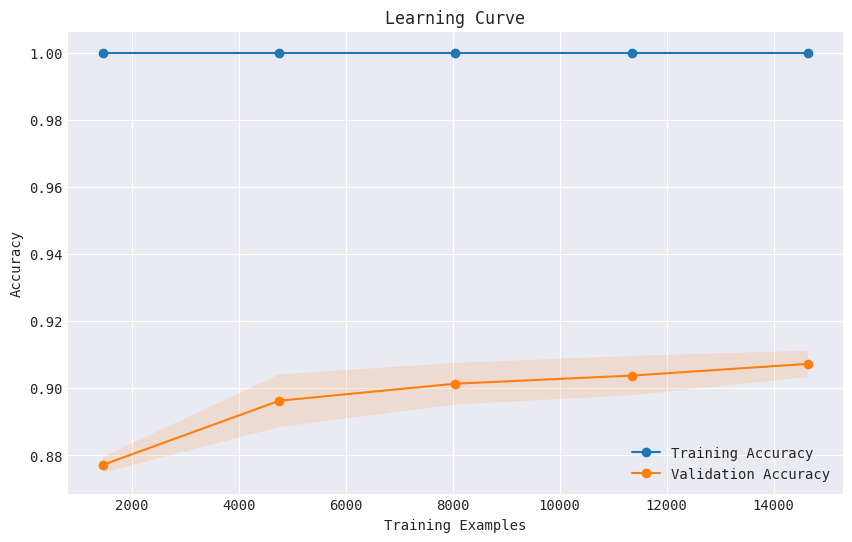

In [63]:
#Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(votingClf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

plt.show()

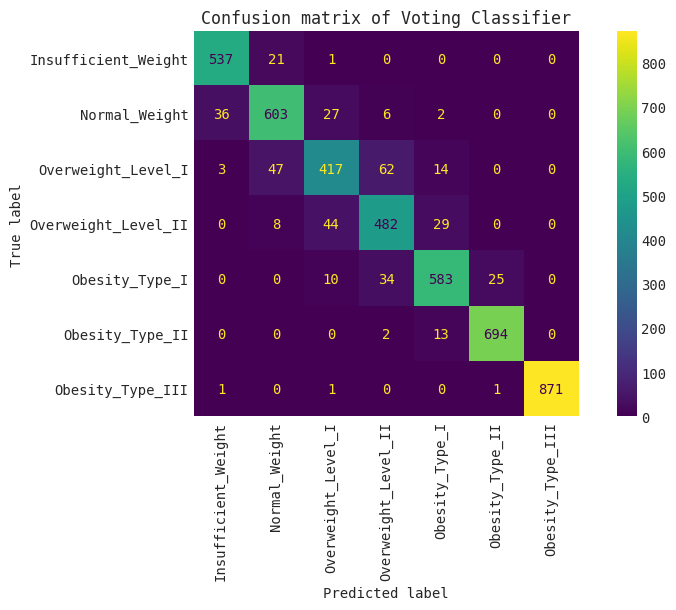

In [64]:
target_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(target_names, rotation=90)  
ax.yaxis.set_ticklabels(target_names)
ax.grid(False)  
_ = ax.set_title("Confusion matrix of Voting Classifier")
plt.show()

In [65]:
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.95       559
      Normal_Weight       0.89      0.89      0.89       674
 Overweight_Level_I       0.83      0.77      0.80       543
Overweight_Level_II       0.82      0.86      0.84       563
     Obesity_Type_I       0.91      0.89      0.90       652
    Obesity_Type_II       0.96      0.98      0.97       709
   Obesity_Type_III       1.00      1.00      1.00       874

           accuracy                           0.92      4574
          macro avg       0.91      0.91      0.91      4574
       weighted avg       0.91      0.92      0.91      4574



In [66]:
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 20}",0.0117,3.4113,0.8297,0.8484,knn
1,"{'penalty': 'l2', 'C': 10}",15.6687,0.0051,0.8700,0.8720,logistic_regression
2,"{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}",0.1437,0.0051,0.8831,0.9071,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy'}",14.4901,0.4004,0.8965,0.9222,random_forest
4,"{'n_estimators': 500, 'max_depth': 15}",24.1672,0.7437,0.9057,1.0000,xg_boost
5,"XGBClassifier(n_estimators = 500, max_depth = 15); RandomForestClassifier(n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = entropy); XGBClassifier(n_estimators = 100, max_depth = 10)",43.9071,1.2480,0.9072,1.0000,voting_classifier
6,{'penalty': None},75.1169,0.0103,0.8754,0.8782,logistic_regression_feateng


In [67]:
df_results.to_csv('result_report_new.csv')